In [ ]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import os
import time

In [ ]:
# Set visibible GPU
gpu_num: int = 2
os.environ['CUDA_VISIBLE_DEVICES']=f'{gpu_num}'

In [ ]:
# Configure TF GPU growth
import kepler_sieve
from tf_utils import gpu_grow_memory
gpu_grow_memory(verbose=True)

In [4]:
# MSE Imports
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, perturb_elts, random_elts, elts_add_mixture_params, elts_add_H
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, MixtureParameters, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt_cart, nearest_ast_elt_cov, elt_q_norm
from element_eda import score_by_elt
from asteroid_dataframe import calc_ast_data, spline_ast_vec_df
from astro_utils import deg2dist, dist2deg, dist2sec

In [5]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [6]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

## Load ZTF Data and Batch of Orbital Elements

In [7]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [8]:
# Load ztf nearest asteroid data
ztf_ast = load_ztf_nearest_ast()

In [9]:
# Asteroid numbers and hit counts
ast_num, hit_count = calc_hit_freq(ztf=ztf_ast, thresh_sec=2.0)

# Sort the hit counts in descending order and find the top batch_size
idx = np.argsort(hit_count)[::-1]

# Extract the asteroid number and hit count for this batch
ast_num_best = ast_num[idx]
hit_count_best = hit_count[idx]

In [10]:
# Parameters to build elements batch
batch_size = 64

# Batch of unperturbed elements
elts_ast = asteroid_elts(ast_nums=ast_num_best[0:batch_size])

In [11]:
# # Review unperturbed elements
# elts_ast

In [12]:
# Inputs to perturb elements: large
sigma_a = 0.05
sigma_e = 0.01
sigma_inc_deg = 0.25
sigma_f_deg = 1.0
sigma_Omega_deg = 1.0
sigma_omega_deg = 1.0
mask_pert = None
random_seed = 42

In [13]:
# Perturb orbital elements
elts_pert= perturb_elts(elts_ast, sigma_a=sigma_a, sigma_e=sigma_e, 
                    sigma_inc_deg=sigma_inc_deg, sigma_f_deg=sigma_f_deg, 
                    sigma_Omega_deg=sigma_Omega_deg, sigma_omega_deg=sigma_omega_deg,
                    mask_pert=mask_pert, random_seed=random_seed)

In [14]:
# Choose which elements to search on
elts = elts_pert

In [15]:
# # Search for nearest asteroids to these elements
# elts_near = nearest_ast_elt(elts)

In [16]:
# Review selected initial candidate elements, including the nearest asteroid information
# elts

In [17]:
# Review nearest asteroid to these candidate elements
# elts_near

In [18]:
# How many elements are still closest to the original elements?
# np.sum(elts.nearest_ast_num == elts.element_id)

## Batches of ZTF Data Near Initial Candidate Elements

In [19]:
# Arguments to make_ztf_batch
thresh_deg = 2.0
near_ast = False
regenerate = False

In [20]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [21]:
# Review ZTF elements
ztf_elt

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,...,vz,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit
0,306,733,b'ZTF18abiyevm',567274570115015018,3341,58321.274572,275.834958,-12.178240,0.099376,-0.976101,...,0.004095,0.080910,-0.982320,0.168822,2.050675,0.031258,6447.753750,0.999511,0.801975,False
1,6391,733,b'ZTF18ablpbwh',617122522515015016,8730,58371.122523,272.156750,-10.136454,0.037046,-0.972528,...,0.003837,0.016116,-0.975703,0.218503,2.491969,0.024005,4951.468379,0.999712,0.472962,False
2,6392,733,b'ZTF18ablpbwh',618126362515015025,8913,58372.126366,272.156760,-10.136446,0.037046,-0.972528,...,0.003830,0.017464,-0.975564,0.219021,2.503645,0.022568,4655.153797,0.999745,0.418050,False
3,6393,733,b'ZTF18ablpbwh',611146562515015015,7585,58365.146562,272.156733,-10.136444,0.037046,-0.972528,...,0.003876,0.010155,-0.976524,0.215169,2.423439,0.030883,6370.298847,0.999523,0.782824,False
4,12249,733,b'ZTF18ablwzcc',584190354815015015,4647,58338.190359,273.272132,-13.497675,0.055502,-0.983530,...,0.004023,0.030085,-0.980846,0.192450,2.155818,0.032724,6750.065879,0.999465,0.878934,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290766,5650772,324582,b'ZTF20aaqvhnd',1150176700415015000,96618,58904.176701,48.664349,31.318054,0.564235,0.795279,...,-0.001786,0.584015,0.786561,0.200621,2.748814,0.030221,6233.797319,0.999543,0.749638,False
290767,5650773,324582,b'ZTF20aaqvhns',1150176245615015007,96617,58904.176250,45.820577,29.378228,0.607285,0.768505,...,-0.001786,0.584016,0.786559,0.200622,2.748808,0.029465,6077.915470,0.999566,0.712618,False
290768,5650789,324582,b'ZTF20aaqvhnm',1150176245015015006,96617,58904.176250,48.881586,28.300138,0.579016,0.797156,...,-0.001786,0.584016,0.786559,0.200622,2.748808,0.031743,6547.783696,0.999496,0.827049,False
290769,5650791,324582,b'ZTF20aaqvhog',1150176244815015007,96617,58904.176250,49.429756,29.370649,0.566783,0.802441,...,-0.001786,0.584016,0.786559,0.200622,2.748808,0.027275,5625.990260,0.999628,0.610591,False


In [22]:
# Score by element - perturbed
score_by_elt = ztf_score_by_elt(ztf_elt)

In [23]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt, score_by_elt, 'Perturbed Asteroids')

ZTF Element Dataframe Perturbed Asteroids:
                  Total     (Per Batch)
Observations   :   290771   (     4543)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :      42.77
Sqrt(batch_obs):      67.40
Mean t_score   :       0.58


In [24]:
# Mixture parameters
num_hits: int = 10
R_deg: float = 0.5

In [25]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, num_hits=num_hits, R_deg=R_deg, thresh_deg=thresh_deg)

In [26]:
# Add brightness parameter H
elts_add_H(elts=elts)

In [27]:
# Review perturbed elements; includes nearest asteroid number and distance
elts

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,thresh_s,H,sigma_mag
0,51921,2.736430,0.219134,0.499988,4.721815,2.452489,-1.129754,58600.0,10,0.008727,0.034905,16.5,4.0
1,59244,2.616575,0.266087,0.462848,5.725946,1.777382,-1.623105,58600.0,10,0.008727,0.034905,16.5,4.0
2,15786,1.945213,0.047621,0.385594,6.142435,0.790543,-1.243047,58600.0,10,0.008727,0.034905,16.5,4.0
3,3904,2.758664,0.099270,0.261841,5.463683,2.238942,-1.350620,58600.0,10,0.008727,0.034905,16.5,4.0
4,142999,2.589450,0.192070,0.509382,0.221844,0.928905,-1.314727,58600.0,10,0.008727,0.034905,16.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,11952,2.330603,0.084892,0.117649,0.042808,2.890716,-3.000560,58600.0,10,0.008727,0.034905,16.5,4.0
60,134815,2.550916,0.141660,0.510228,0.284591,0.630896,-0.920797,58600.0,10,0.008727,0.034905,16.5,4.0
61,27860,2.595202,0.098315,0.194023,5.535984,3.255585,3.966790,58600.0,10,0.008727,0.034905,16.5,4.0
62,85937,2.216242,0.195323,0.437115,5.285351,3.172956,3.921169,58600.0,10,0.008727,0.034905,16.5,4.0


## Build Asteroid Search Model

In [28]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [29]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0
save_at_end: bool = True

In [30]:
# Build asteroid search model
model = AsteroidSearchModel(
                elts=elts, ztf_elt=ztf_elt, 
                site_name=site_name, thresh_deg=thresh_deg, 
                learning_rate=learning_rate, clipnorm=clipnorm,
                file_name=f'candidate_elt_pert_large_{random_seed:04d}.h5',
                name='model')

In [31]:
# model.load()

In [32]:
# Report before training starts
model.report()


Good elements (hits >= 10):   0.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:      nan  :    nan :      nan :      nan
Mean Bad :     0.52  :   0.00 :  1800.46 :  7200.00
Mean     :     0.52  :   0.00 :  1800.46 :  7200.00
Median   :     0.19  :   0.00 :  1807.21 :  7200.00
GeoMean  :     1.14  :   0.00 :  1800.45 :  7200.99
Min      :    -1.07  :   0.00 :  1792.81 :  7200.00
Max      :     4.01  :   0.00 :  1807.22 :  7200.00
Trained for 0 batches over 0 epochs and 0 episodes (elapsed time 0 seconds).


/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


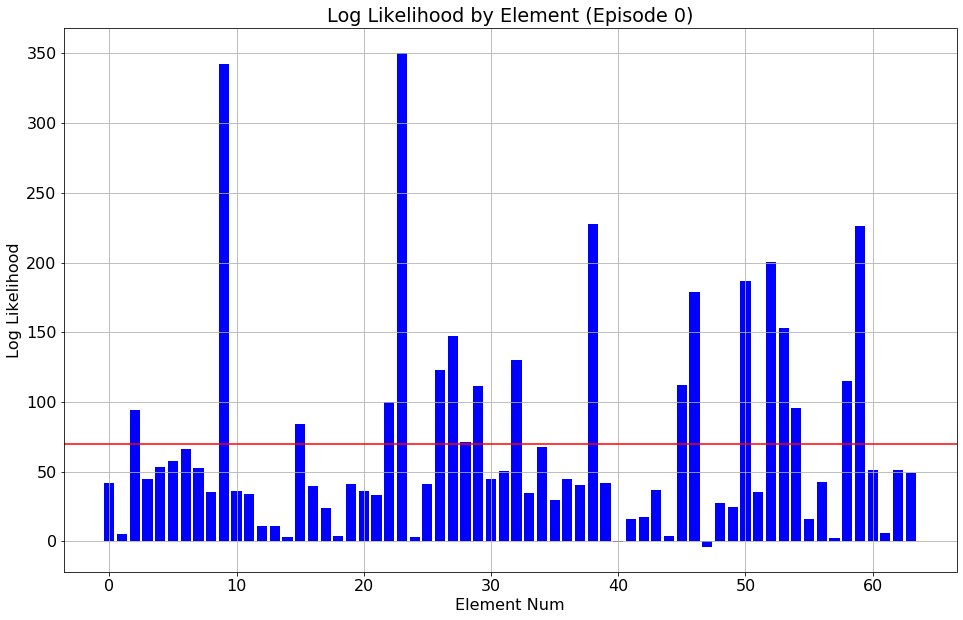

In [33]:
fig, ax = model.plot_bar('log_like', sorted=False)

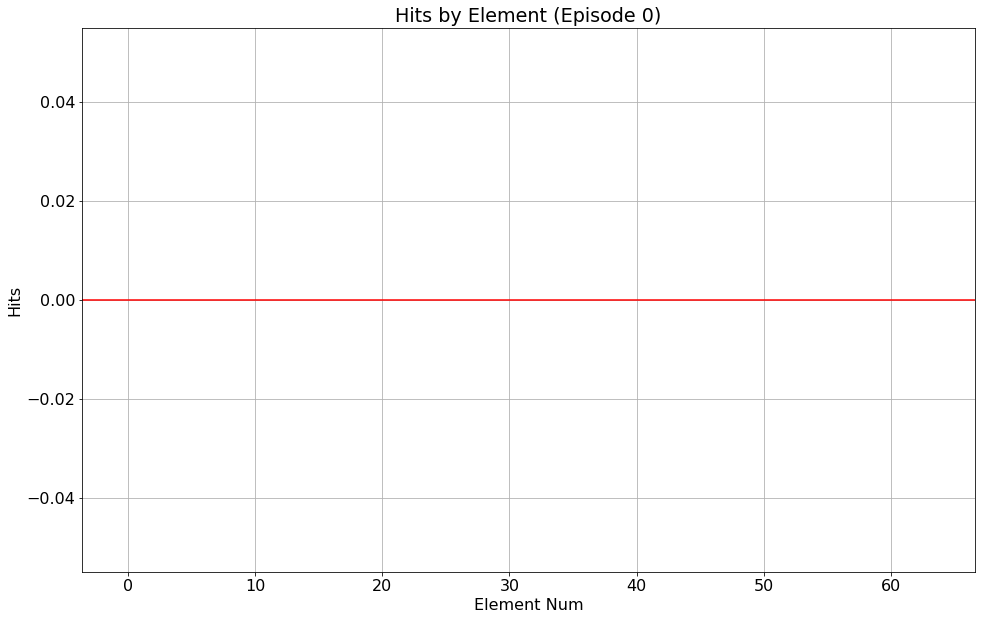

In [34]:
fig, ax = model.plot_bar('hits', sorted=False)

In [35]:
# raise ValueError

## Automated Training with Sieve Method


********************************************************************************
Round 1: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 7200.0
********************************************************************************

Training episode 0: Epoch    0, Batch      0
effective_learning_rate=2.441e-04, training_time 0 sec.
Train on 4096 samples
Epoch 1/4
4096/4096 [==============================] - 5s 1ms/sample - loss: -85670.9257
Epoch 2/4
4096/4096 [==============================] - 2s 475us/sample - loss: -125321.0294
Epoch 3/4
4096/4096 [==============================] - 2s 467us/sample - loss: -178649.5129
Epoch 4/4
4096/4096 [==============================] - 2s 467us/sample - loss: -248864.6787
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:   1599.71 :  1599.71 :      nan arc seconds
Geom Mean Threshold :   7200.00 :  7200.00 :      nan arc seconds
Mean Log Likelihood :      1.58 :     1.58 :      nan
Mean Hits           :      0.0

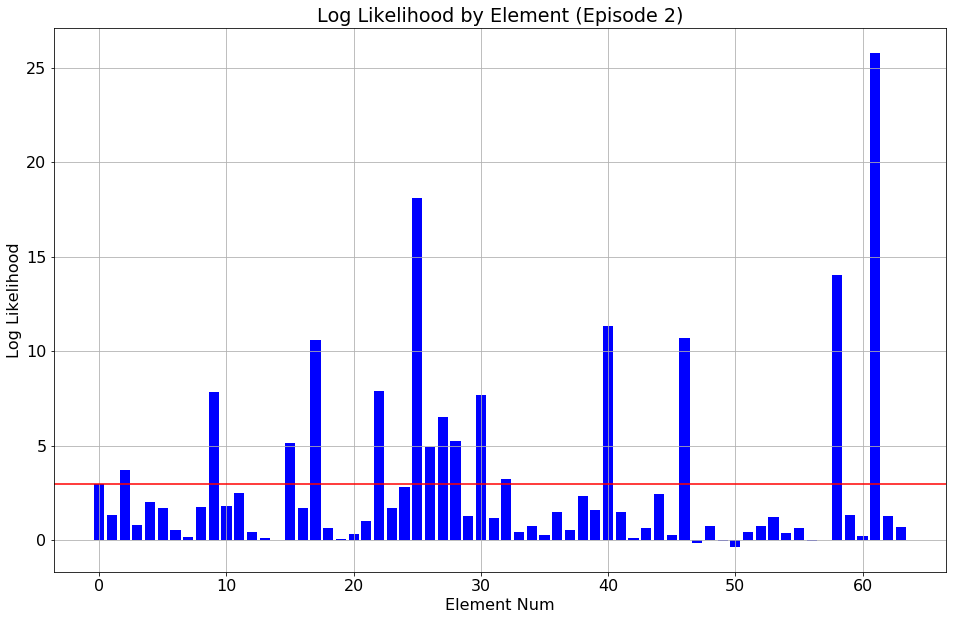

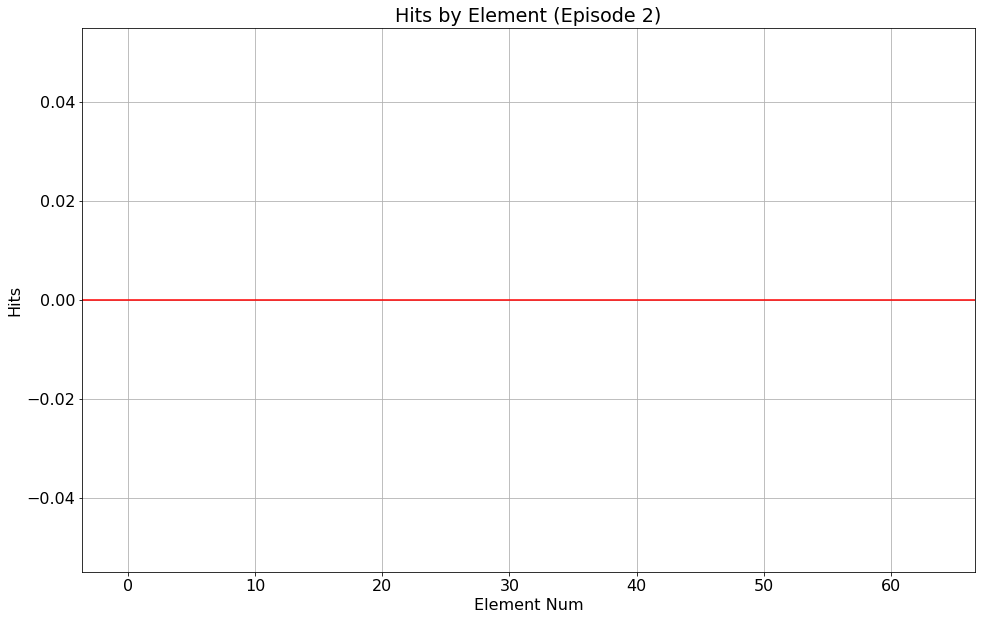


********************************************************************************
Round 2: 2048 batches @ LR 2^-15 in joint mode.
********************************************************************************
Applying learning_rate 3.05e-05 (2.0^-15.0) for adaptive training.

Training episode 2: Epoch    8, Batch    512
effective_learning_rate=2.384e-04, training_time 31 sec.
Train on 4096 samples
Epoch 9/12
4096/4096 [==============================] - 7s 2ms/sample - loss: -549.0763
Epoch 10/12
4096/4096 [==============================] - 2s 566us/sample - loss: -707.6655
Epoch 11/12
4096/4096 [==============================] - 2s 568us/sample - loss: -801.9357
Epoch 12/12
4096/4096 [==============================] - 2s 545us/sample - loss: -896.9034
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:   1359.38 :  1359.38 :      nan arc seconds
Geom Mean Threshold :   7200.00 :  7200.00 :      nan arc seconds
Mean Log Likelihood :     14.90 :    14.90 : 

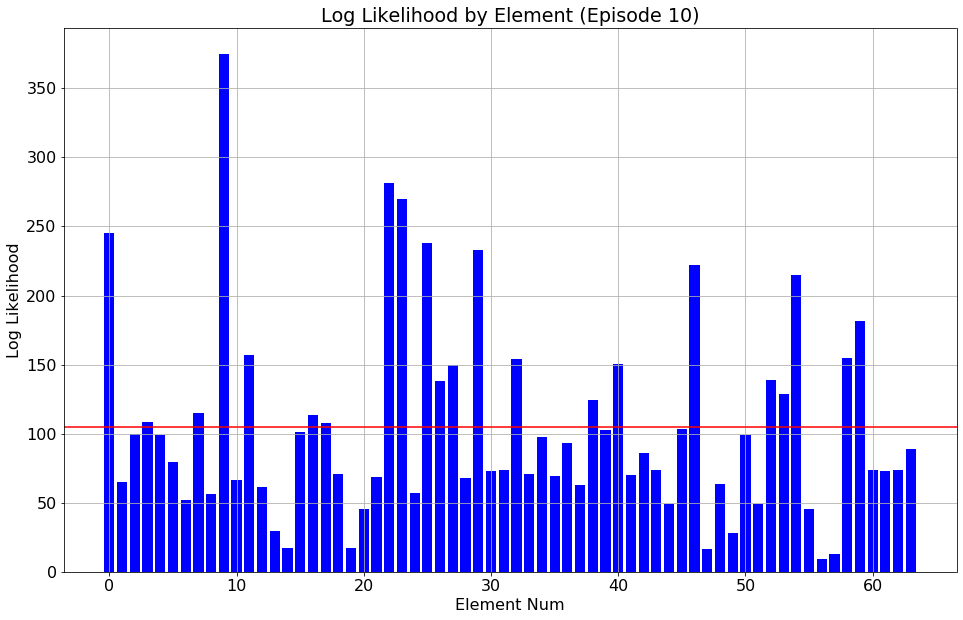

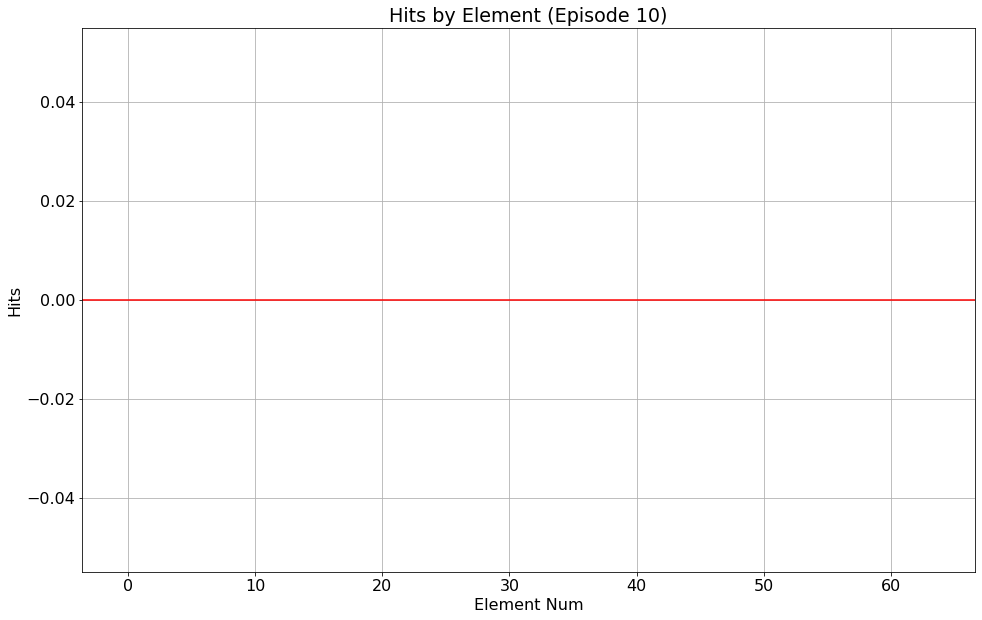


********************************************************************************
Round 3: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 5400.0
********************************************************************************

Training episode 10: Epoch   40, Batch   2560
effective_learning_rate=2.441e-04, training_time 123 sec.
Train on 4096 samples
Epoch 41/44
4096/4096 [==============================] - 5s 1ms/sample - loss: -24498827.9688
Epoch 42/44
4096/4096 [==============================] - 2s 474us/sample - loss: -27420521.5625
Epoch 43/44
4096/4096 [==============================] - 2s 465us/sample - loss: -30513842.6875
Epoch 44/44
4096/4096 [==============================] - 2s 476us/sample - loss: -33791726.2188
Adjusted element weight down on 13 candidate elements. Mean weight = 8.98e-01
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    546.64 :   546.64 :      nan arc seconds
Geom Mean Threshold :   5390.10 :  5390.10 :      na

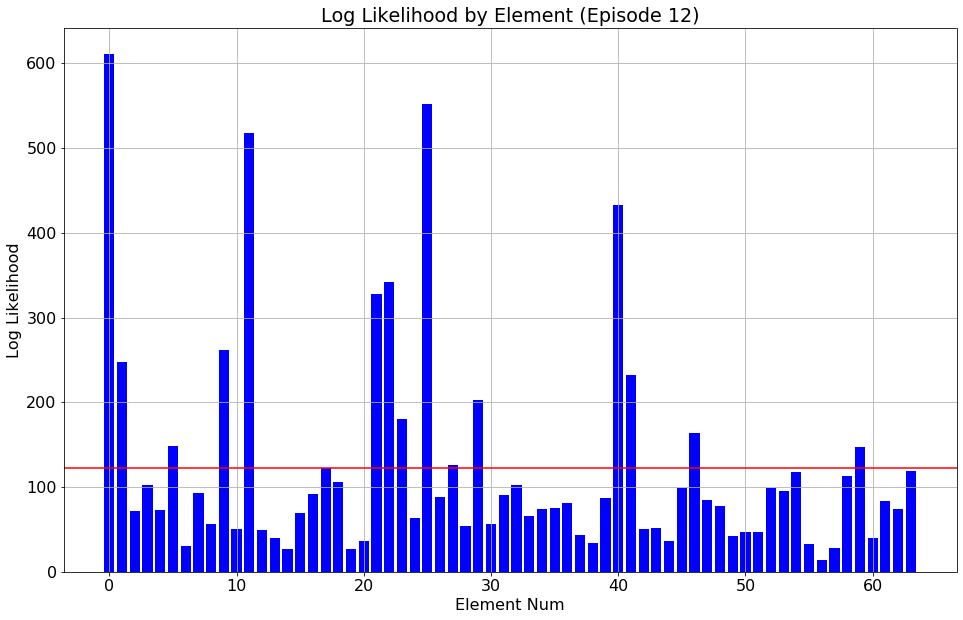

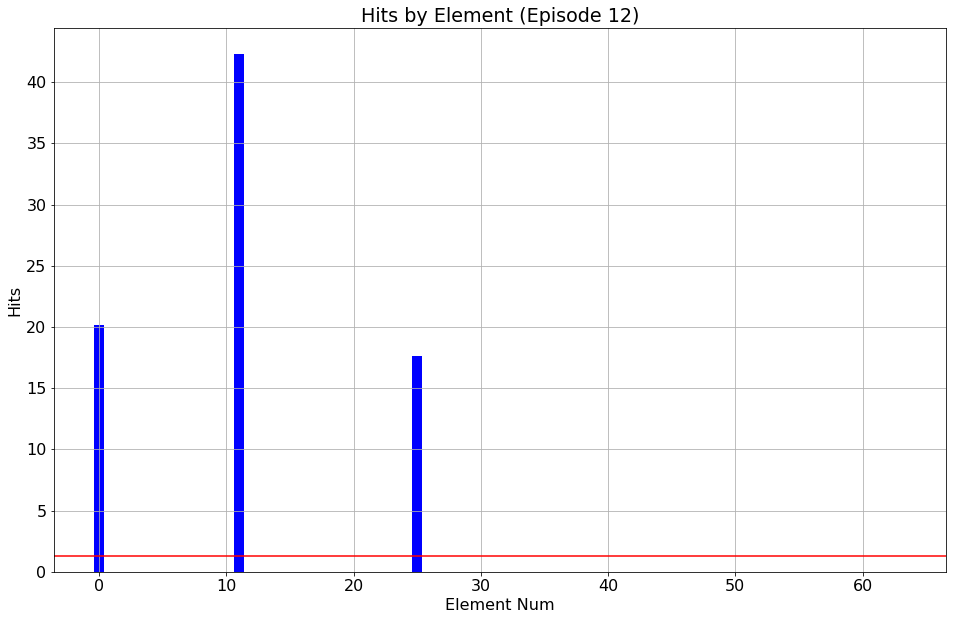


********************************************************************************
Round 4: 2048 batches @ LR 2^-15 in joint mode.
********************************************************************************
Applying learning_rate 3.05e-05 (2.0^-15.0) for adaptive training.

Training episode 12: Epoch   48, Batch   3072
effective_learning_rate=1.907e-04, training_time 144 sec.
Train on 4096 samples
Epoch 49/52
4096/4096 [==============================] - 6s 1ms/sample - loss: -6750.8246
Epoch 50/52
4096/4096 [==============================] - 2s 577us/sample - loss: -7032.1582
Epoch 51/52
4096/4096 [==============================] - 2s 587us/sample - loss: -7174.0674
Epoch 52/52
4096/4096 [==============================] - 2s 584us/sample - loss: -7298.8353
Adjusted element weight down on 5 candidate elements. Mean weight = 9.28e-01
                    \  All Elts : Bad Elts : Good Elts (3)
Geom Mean Resolution:    409.54 :   433.78 :   127.19 arc seconds
Geom Mean Threshold :   527

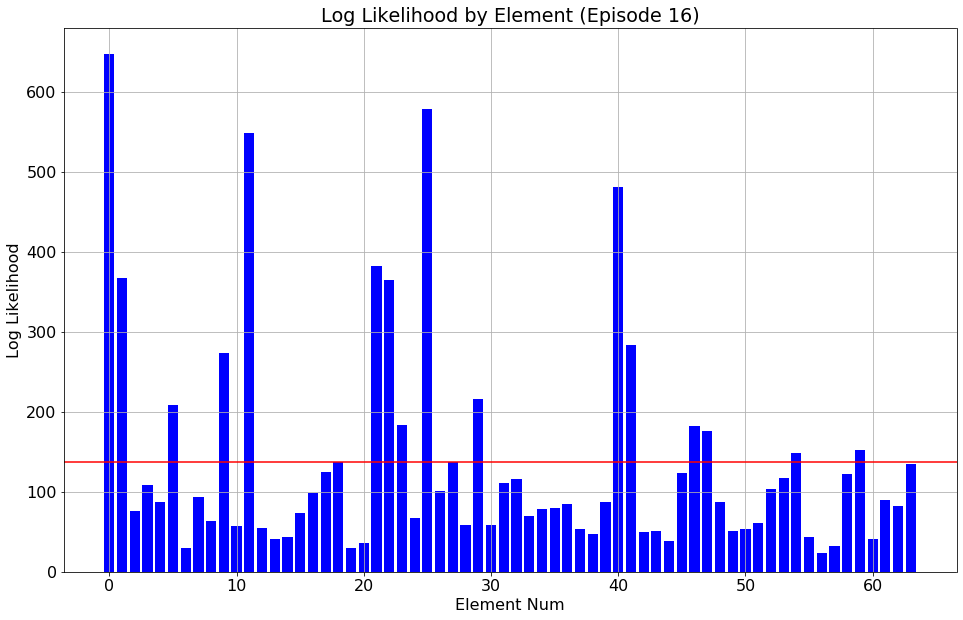

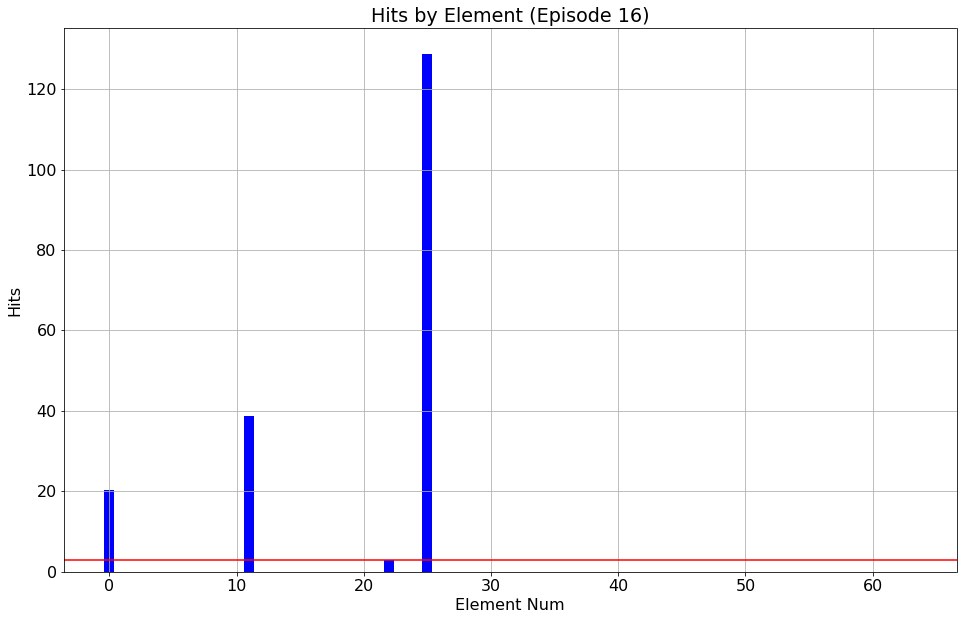


********************************************************************************
Round 5: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 3600.0
********************************************************************************

Training episode 16: Epoch   64, Batch   4096
effective_learning_rate=2.441e-04, training_time 193 sec.
Train on 4096 samples
Epoch 65/68
4096/4096 [==============================] - 5s 1ms/sample - loss: -62196625.7500
Epoch 66/68
4096/4096 [==============================] - 2s 480us/sample - loss: -69625831.5000
Epoch 67/68
4096/4096 [==============================] - 2s 469us/sample - loss: -77617632.0000
Epoch 68/68
4096/4096 [==============================] - 2s 475us/sample - loss: -85891798.6250
Adjusted element weight down on 14 candidate elements. Mean weight = 8.91e-01
                    \  All Elts : Bad Elts : Good Elts (3)
Geom Mean Resolution:    310.51 :   332.58 :    76.84 arc seconds
Geom Mean Threshold :   3470.41 :  3551.49 :  2170.0

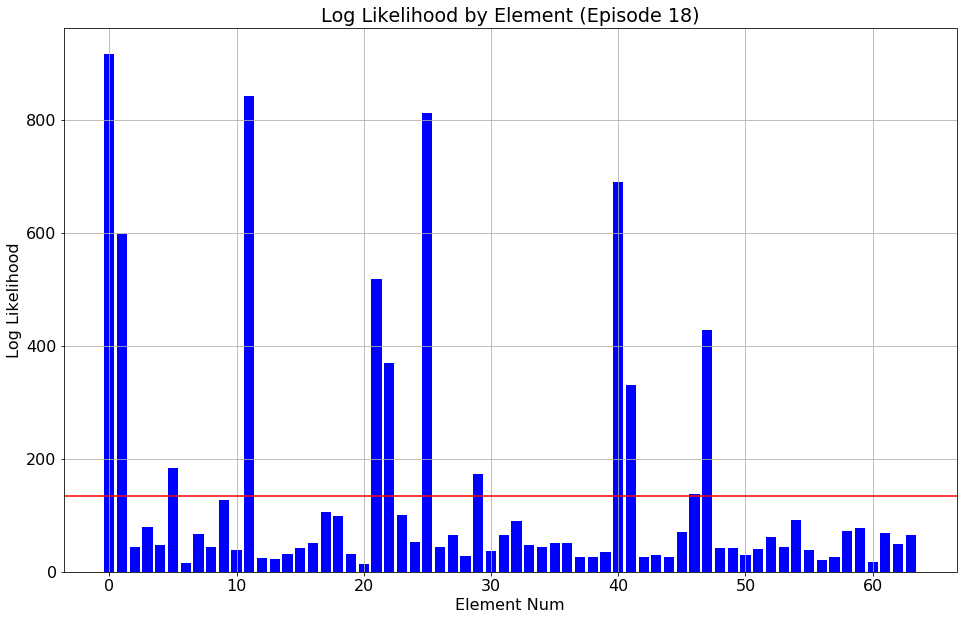

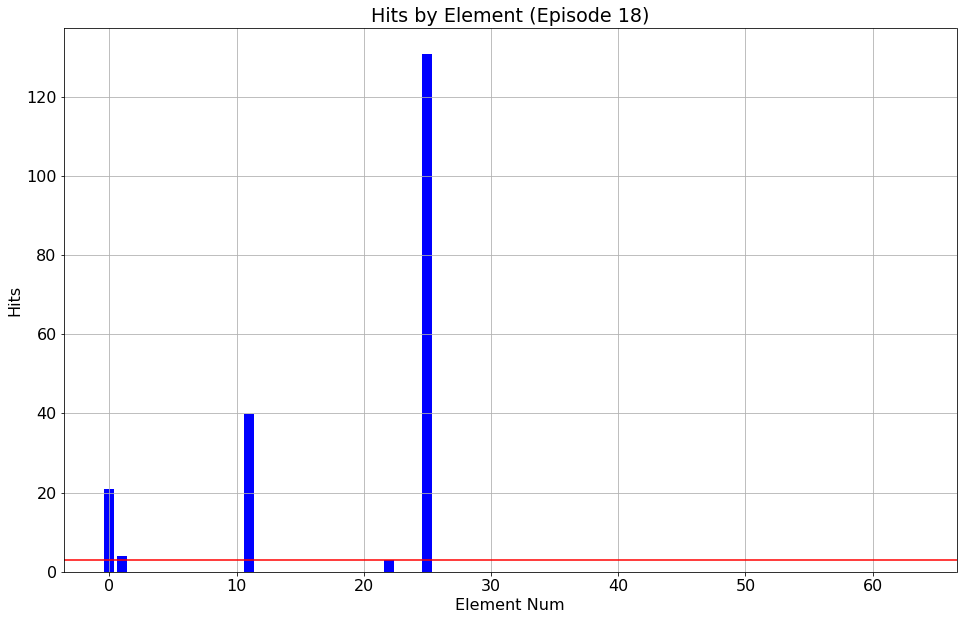


********************************************************************************
Round 6: 2048 batches @ LR 2^-15 in joint mode.
********************************************************************************
Applying learning_rate 3.05e-05 (2.0^-15.0) for adaptive training.

Training episode 18: Epoch   72, Batch   4608
effective_learning_rate=1.640e-04, training_time 215 sec.
Train on 4096 samples
Epoch 73/76
4096/4096 [==============================] - 6s 1ms/sample - loss: -4863.5728
Epoch 74/76
4096/4096 [==============================] - 2s 600us/sample - loss: -5143.7726
Epoch 75/76
4096/4096 [==============================] - 3s 612us/sample - loss: -5274.0969
Epoch 76/76
4096/4096 [==============================] - 2s 603us/sample - loss: -5400.0065
Adjusted element weight down on 64 candidate elements. Mean weight = 5.80e-02
                    \  All Elts : Bad Elts : Good Elts (3)
Geom Mean Resolution:    277.51 :   304.12 :    43.12 arc seconds
Geom Mean Threshold :   33

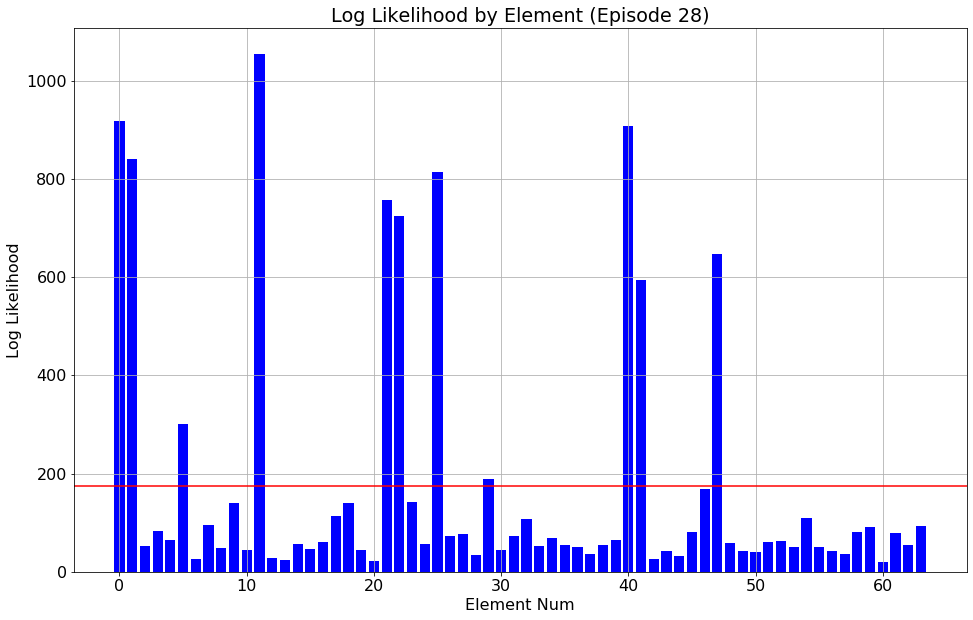

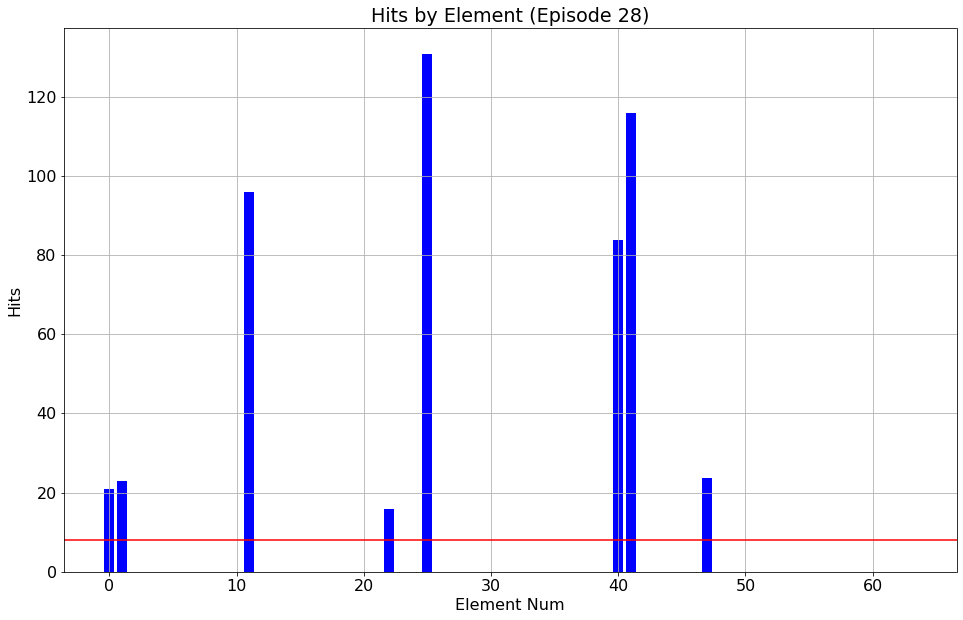


********************************************************************************
Round 7: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 2400.0
********************************************************************************

Training episode 28: Epoch  106, Batch   6784
effective_learning_rate=2.441e-04, training_time 322 sec.
Train on 4096 samples
Epoch 107/110
4096/4096 [==============================] - 5s 1ms/sample - loss: -162633586.0000
Epoch 108/110
4096/4096 [==============================] - 2s 526us/sample - loss: -176818666.0000
Epoch 109/110
4096/4096 [==============================] - 2s 524us/sample - loss: -191308571.0000
Epoch 110/110
4096/4096 [==============================] - 2s 523us/sample - loss: -205845816.2500
Adjusted element weight down on 11 candidate elements. Mean weight = 9.14e-01
                    \  All Elts : Bad Elts : Good Elts (8)
Geom Mean Resolution:    186.15 :   238.72 :    32.63 arc seconds
Geom Mean Threshold :   2232.89 :  2384.

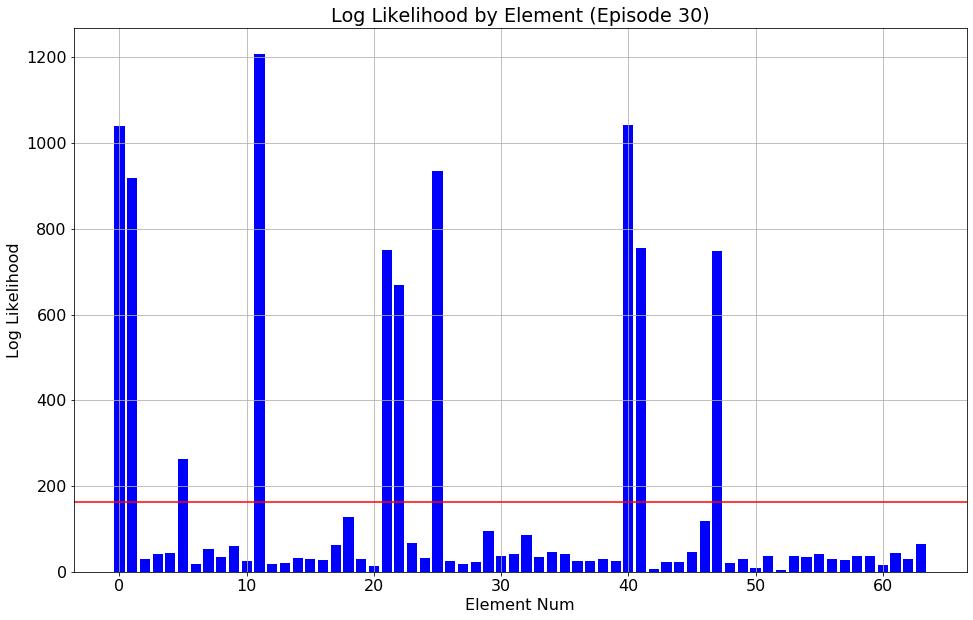

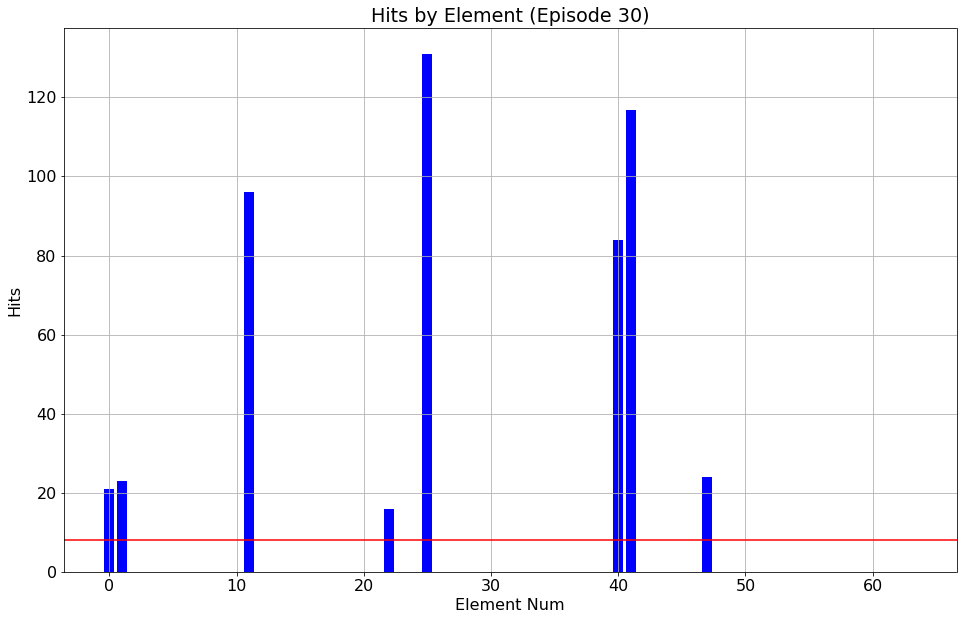


********************************************************************************
Round 8: 2048 batches @ LR 2^-15 in joint mode.
********************************************************************************
Applying learning_rate 3.05e-05 (2.0^-15.0) for adaptive training.

Training episode 30: Epoch  114, Batch   7296
effective_learning_rate=1.860e-04, training_time 346 sec.
Train on 4096 samples
Epoch 115/118
4096/4096 [==============================] - 6s 2ms/sample - loss: inf
Adjusted element weight down on 7 candidate elements. Mean weight = 4.12e-02
                    \  All Elts : Bad Elts : Good Elts (8)
Geom Mean Resolution:    167.12 :   223.58 :    21.79 arc seconds
Geom Mean Threshold :   2146.28 :  2383.43 :  1030.56 arc seconds
Mean Log Likelihood :    163.50 :    55.72 :   917.97
Mean Hits           :     10.27 :     0.00 :    82.15
Good Elements       :      8.00

Training episode 31: Epoch  115, Batch   7360
effective_learning_rate=1.256e-06, training_time 354 se

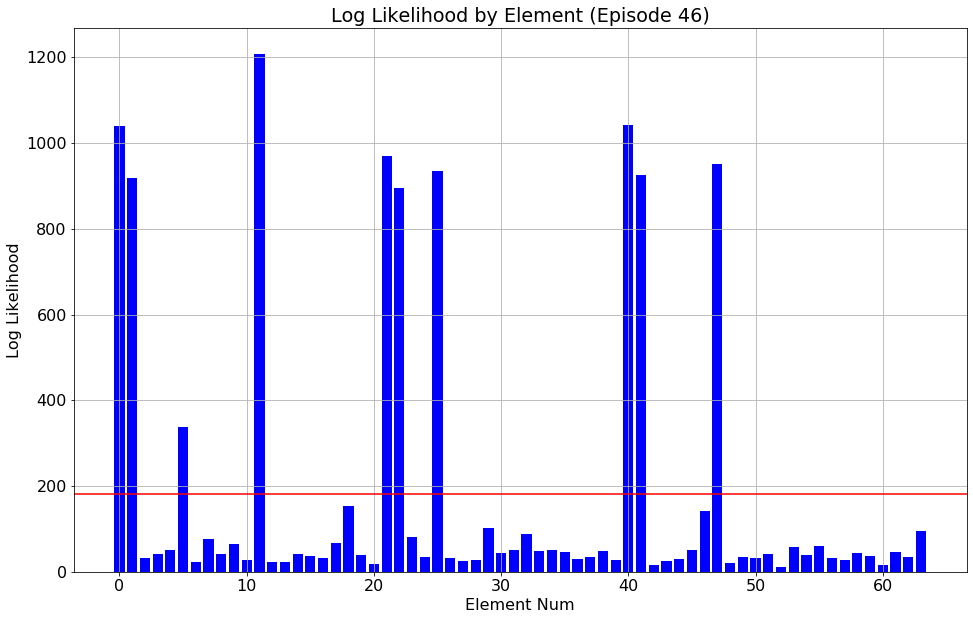

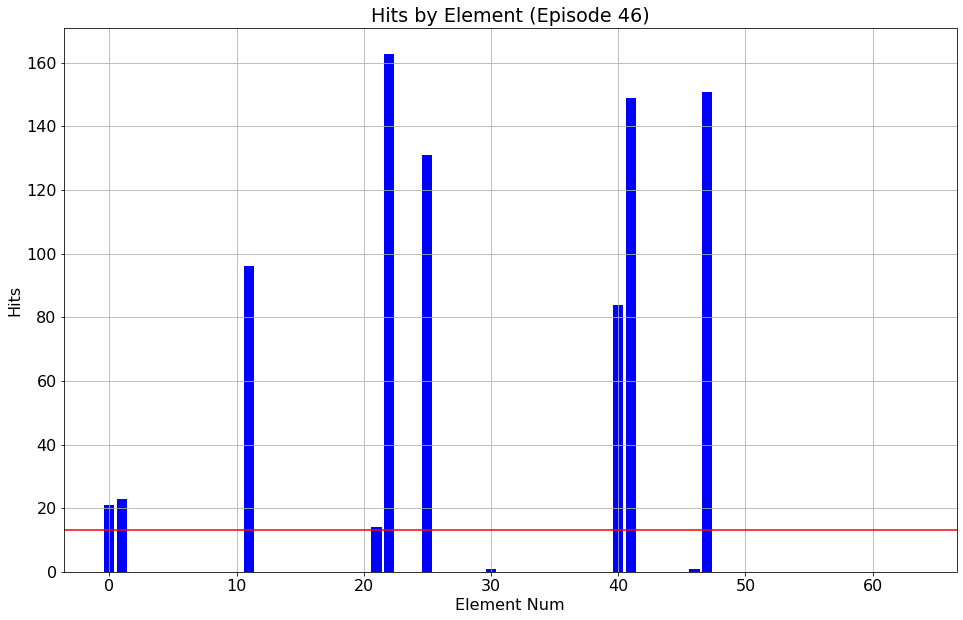


********************************************************************************
Round 5: 1024 batches @ LR 2^-13 in mixture mode.
********************************************************************************
Applying learning_rate 1.22e-04 (2.0^-13.0) for adaptive training.

Training episode 46: Epoch  144, Batch   9216
effective_learning_rate=1.221e-04, training_time 461 sec.
Train on 4096 samples
Epoch 145/148
4096/4096 [==============================] - 5s 1ms/sample - loss: -7235068788736.0000
Epoch 146/148
4096/4096 [==============================] - 3s 618us/sample - loss: -7606248677376.0000
Epoch 147/148
4096/4096 [==============================] - 2s 607us/sample - loss: -7983911280640.0000
Epoch 148/148
4096/4096 [==============================] - 3s 627us/sample - loss: -8349970989056.0000
Adjusted element weight down on 50 candidate elements. Mean weight = 6.09e-01
                    \  All Elts : Bad Elts : Good Elts (9)
Geom Mean Resolution:    130.17 :   181.30 :  

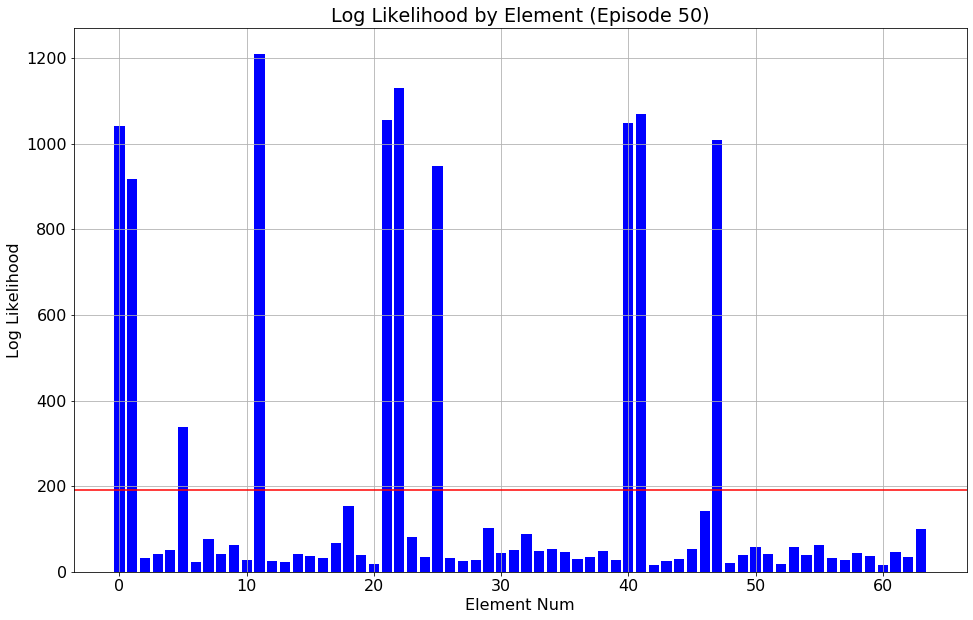

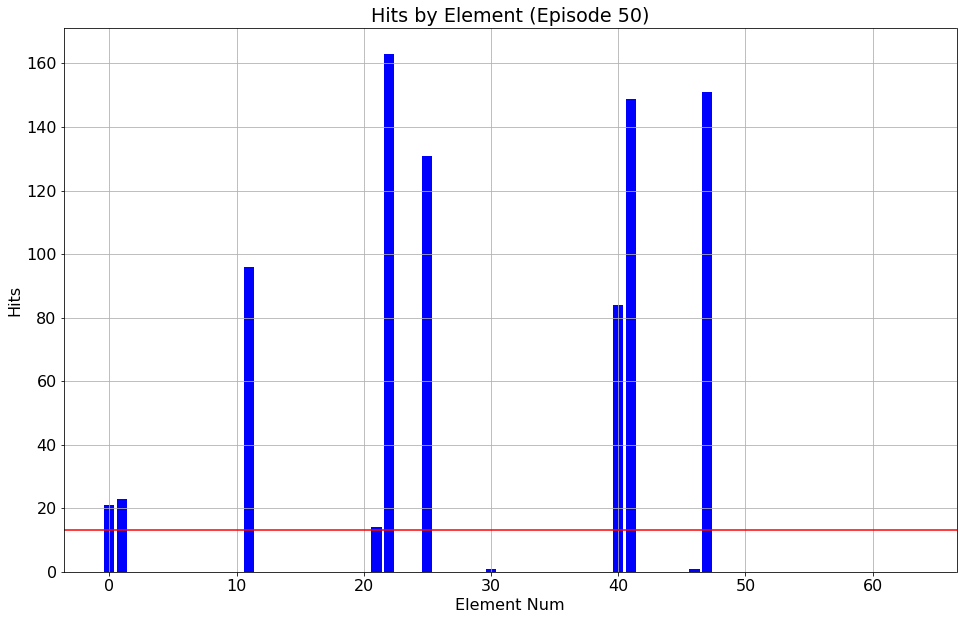


********************************************************************************
Round 6: 2048 batches @ LR 2^-17 in joint mode.
********************************************************************************
Applying learning_rate 7.63e-06 (2.0^-17.0) for adaptive training.

Training episode 50: Epoch  160, Batch  10240
effective_learning_rate=7.629e-06, training_time 509 sec.
Train on 4096 samples
Epoch 161/164
4096/4096 [==============================] - 7s 2ms/sample - loss: inf
Adjusted element weight down on 18 candidate elements. Mean weight = 8.59e-01
                    \  All Elts : Bad Elts : Good Elts (9)
Geom Mean Resolution:    117.46 :   171.29 :    11.71 arc seconds
Geom Mean Threshold :   2019.68 :  2356.15 :   787.63 arc seconds
Mean Log Likelihood :    195.48 :    52.18 :  1071.18
Mean Hits           :     15.84 :     0.09 :   112.09
Good Elements       :      9.00

Training episode 51: Epoch  161, Batch  10304
effective_learning_rate=6.557e-06, training_time 518 s

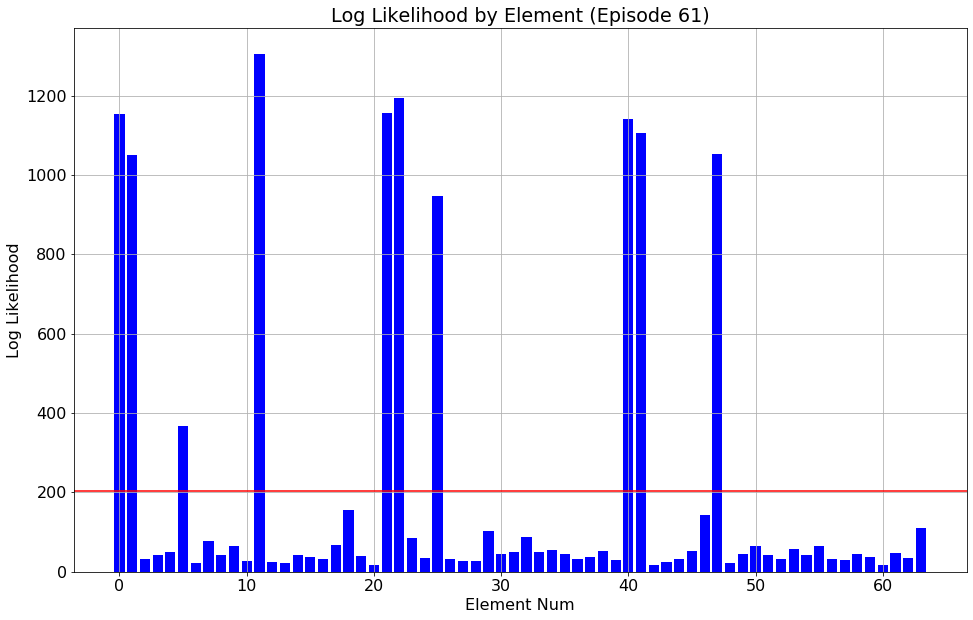

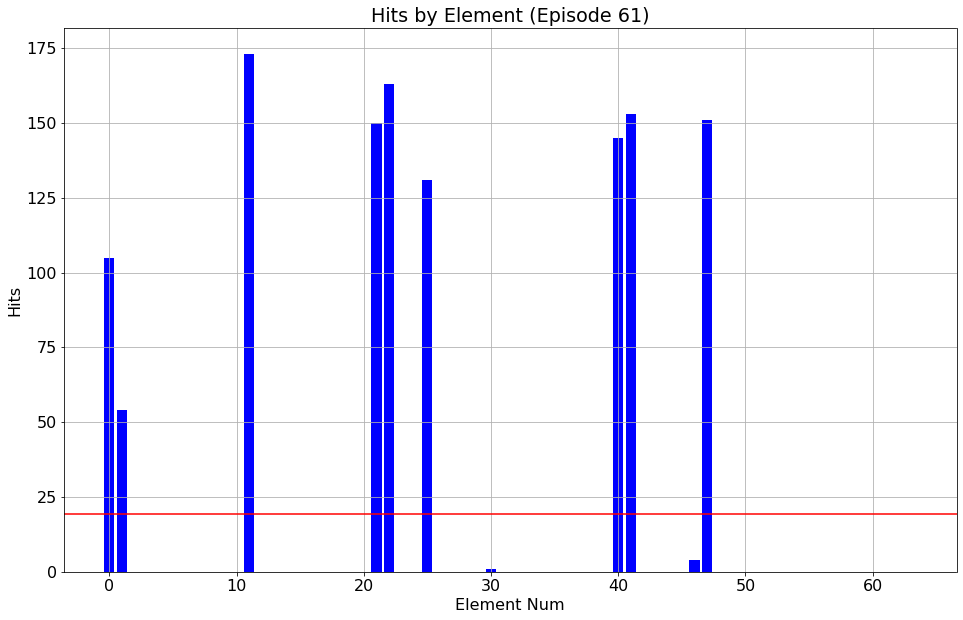


********************************************************************************
Round 7: 512 batches @ LR 2^-17 in joint mode.
********************************************************************************
Applying learning_rate 7.63e-06 (2.0^-17.0) for adaptive training.

Training episode 61: Epoch  195, Batch  12480
effective_learning_rate=7.629e-06, training_time 642 sec.
Train on 4096 samples
Epoch 196/199
4096/4096 [==============================] - 6s 1ms/sample - loss: inf
Adjusted element weight down on 44 candidate elements. Mean weight = 6.56e-01
                    \  All Elts : Bad Elts : Good Elts (9)
Geom Mean Resolution:    110.44 :   162.17 :    10.55 arc seconds
Geom Mean Threshold :   2003.57 :  2364.72 :   727.71 arc seconds
Mean Log Likelihood :    204.19 :    53.82 :  1123.12
Mean Hits           :     19.06 :     0.09 :   134.97
Good Elements       :      9.00

Training episode 62: Epoch  196, Batch  12544
effective_learning_rate=5.007e-06, training_time 650 se

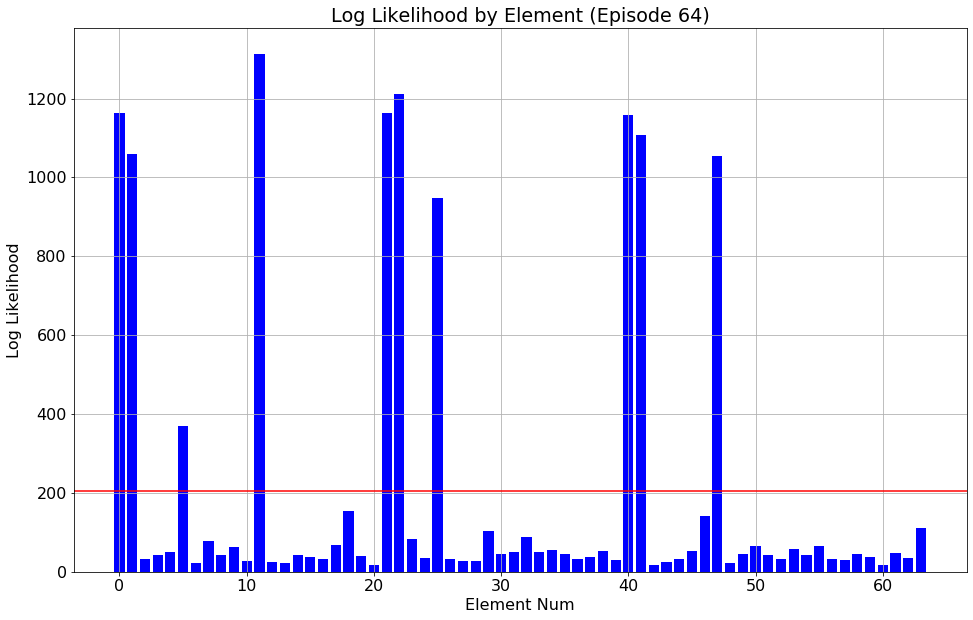

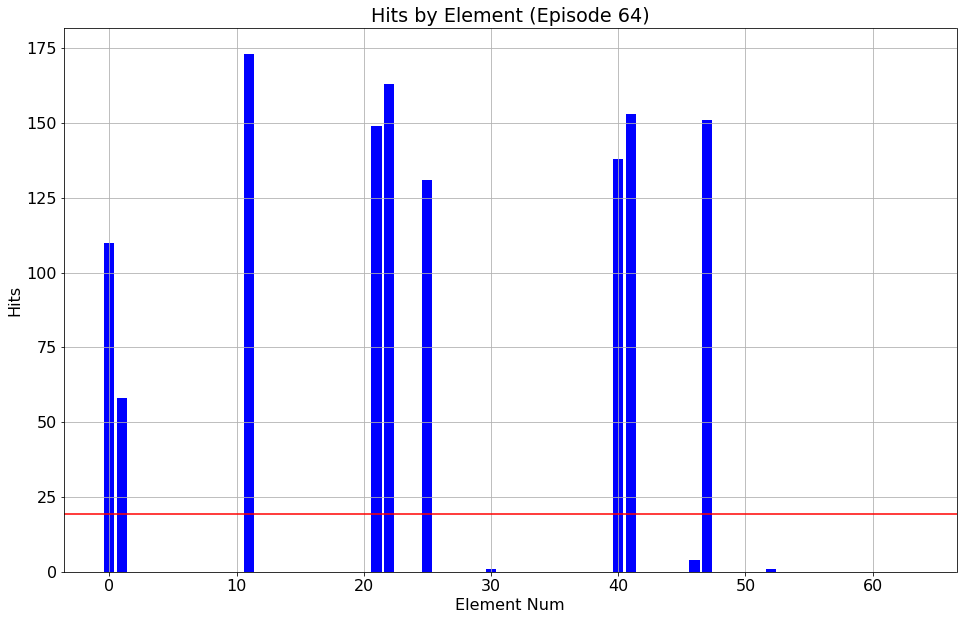

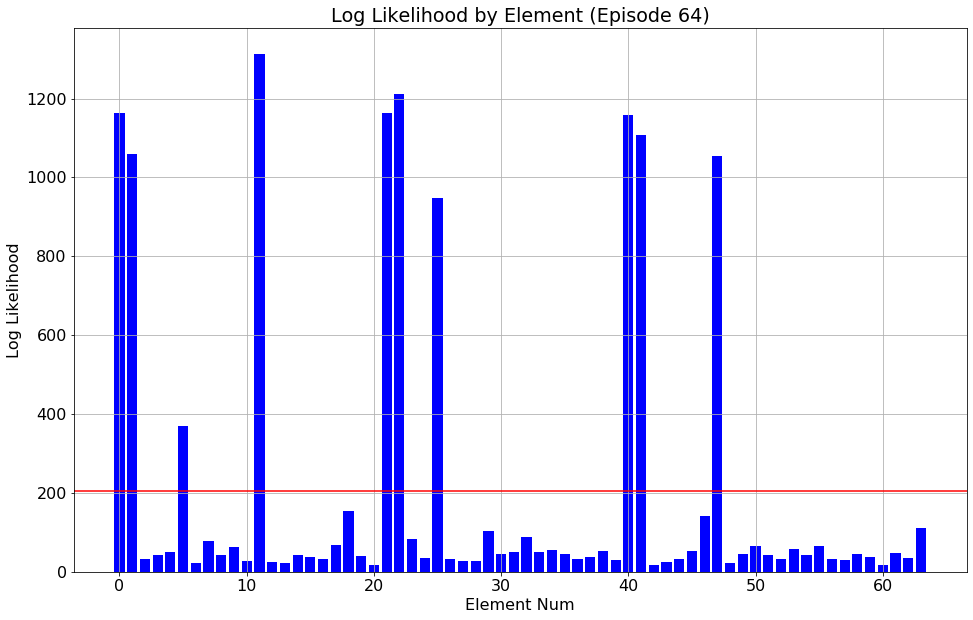

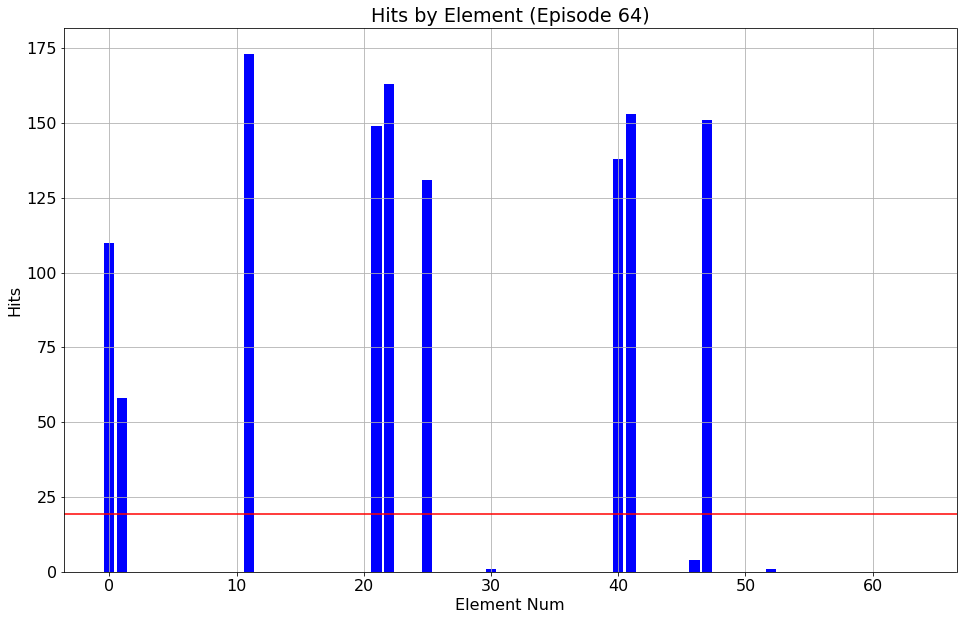

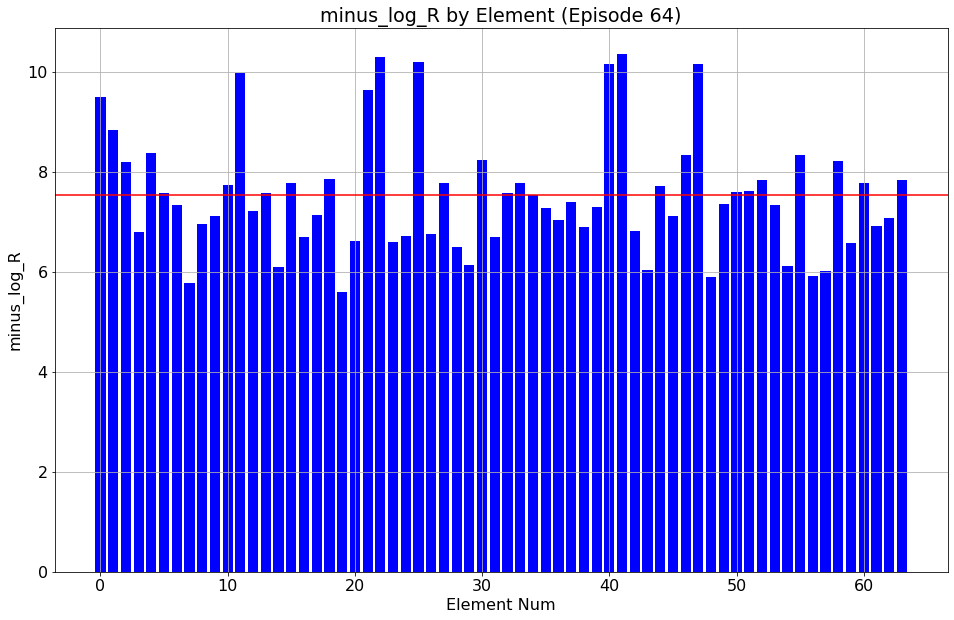

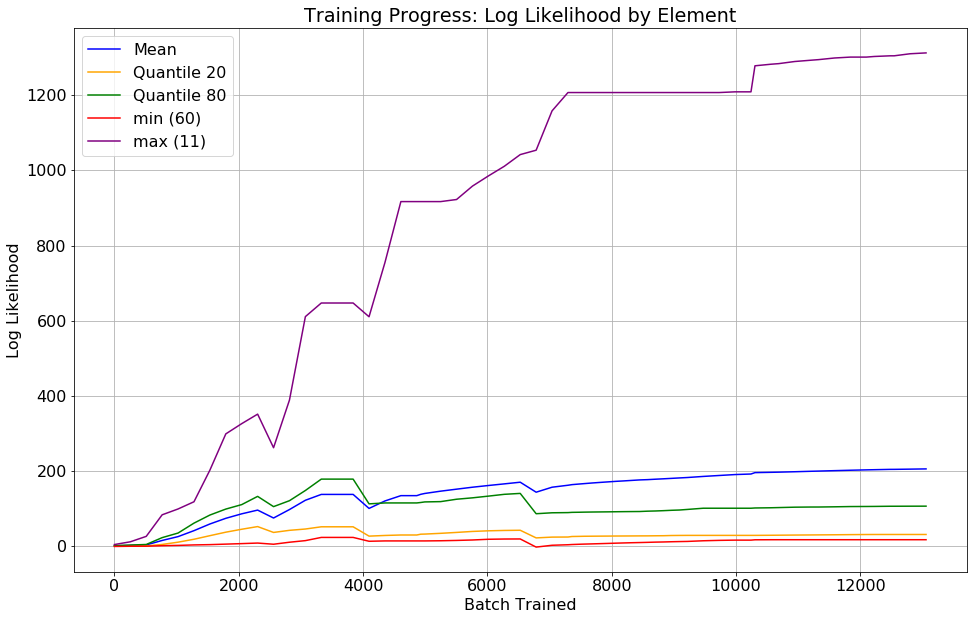

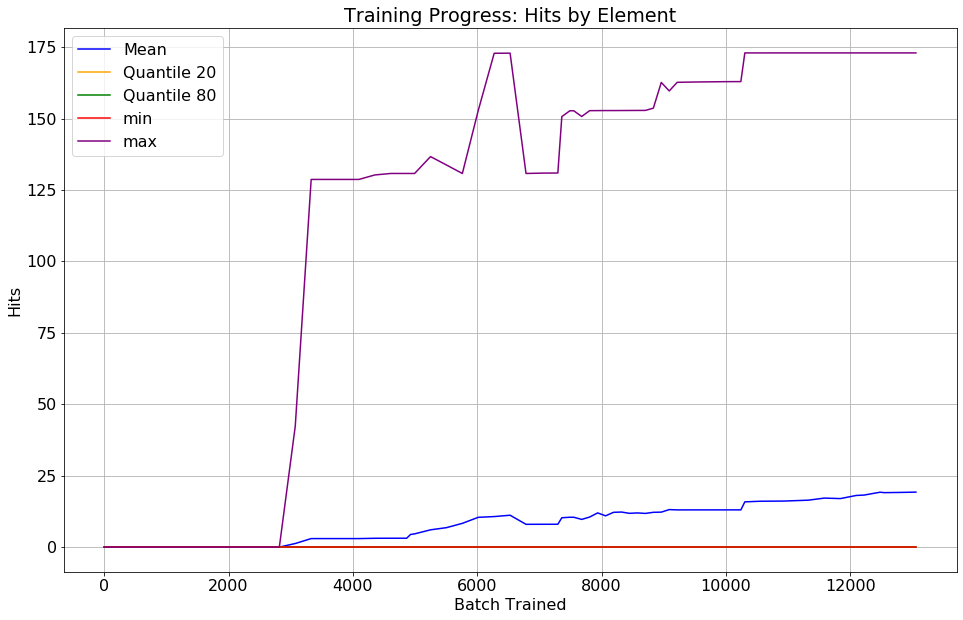

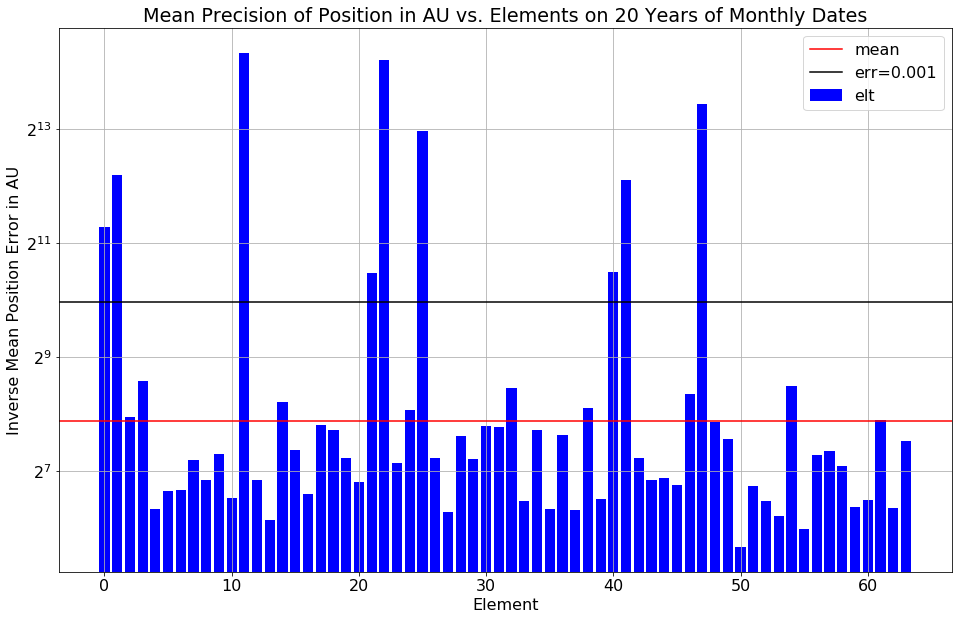

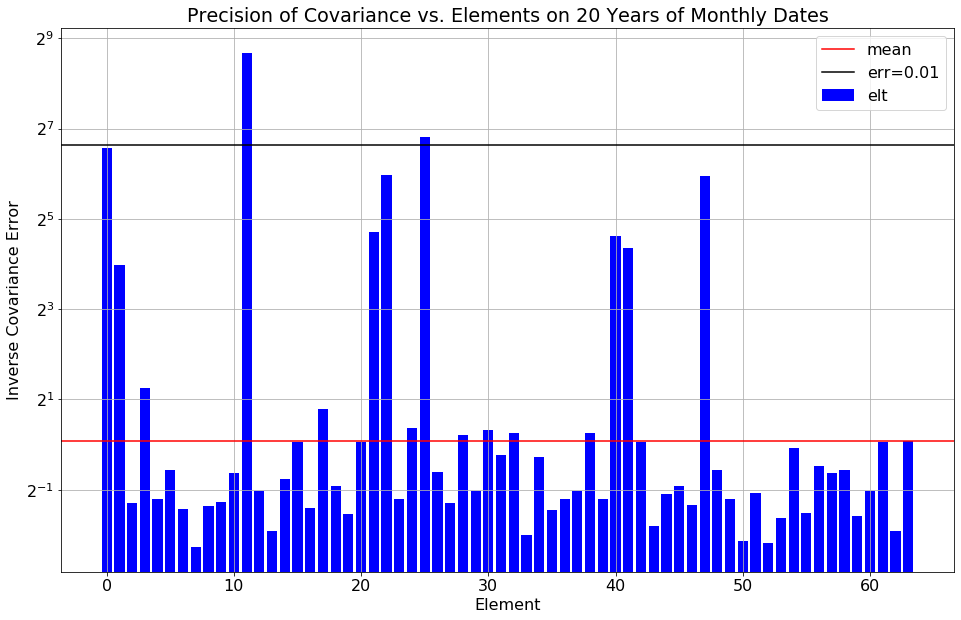

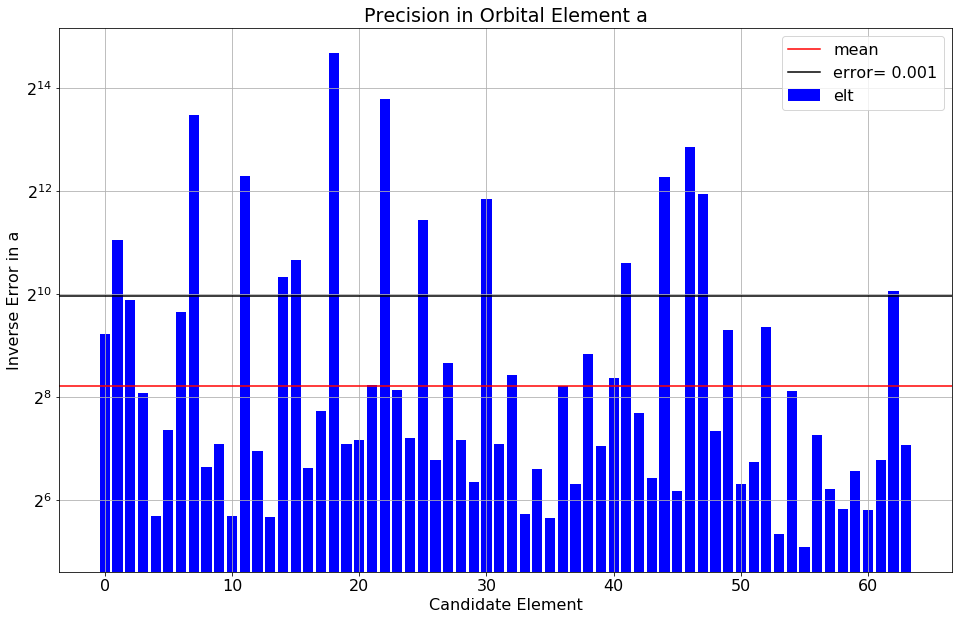

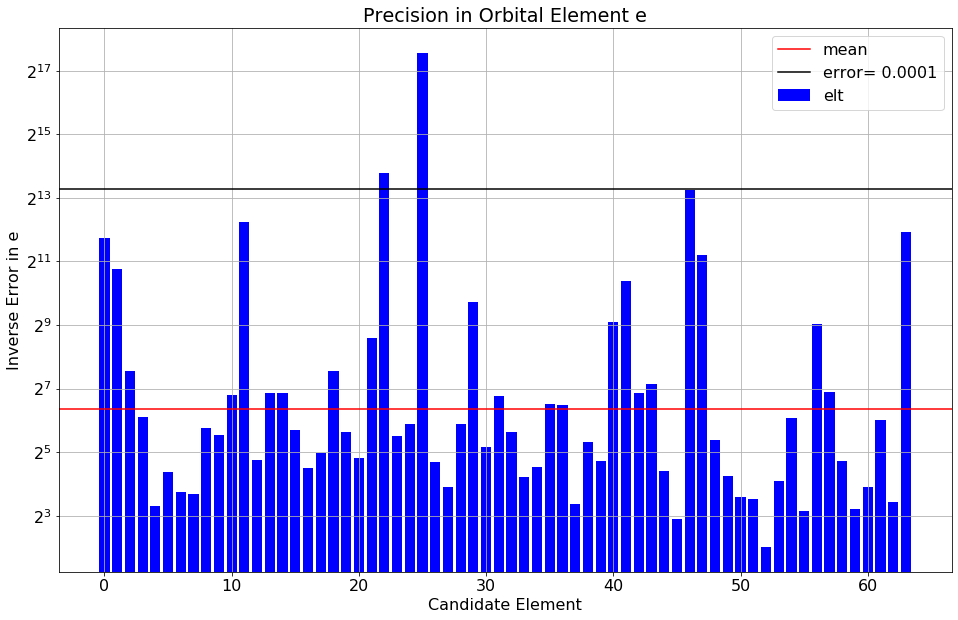

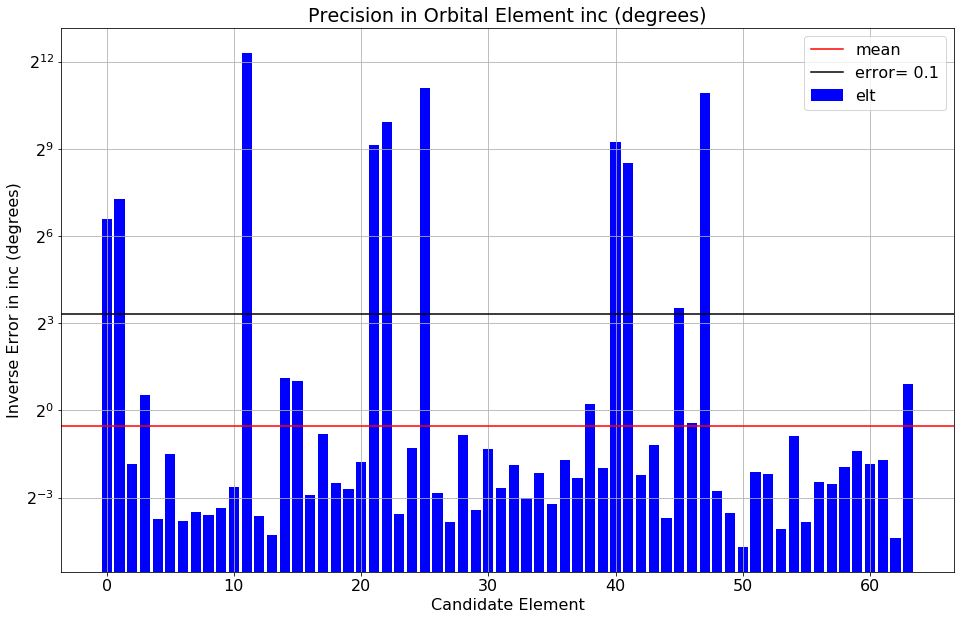

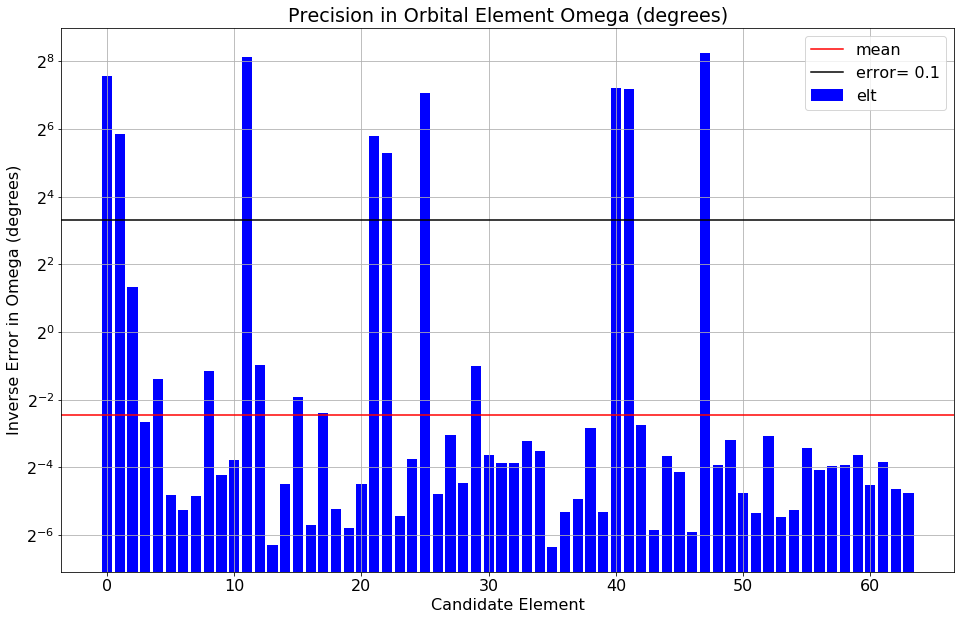

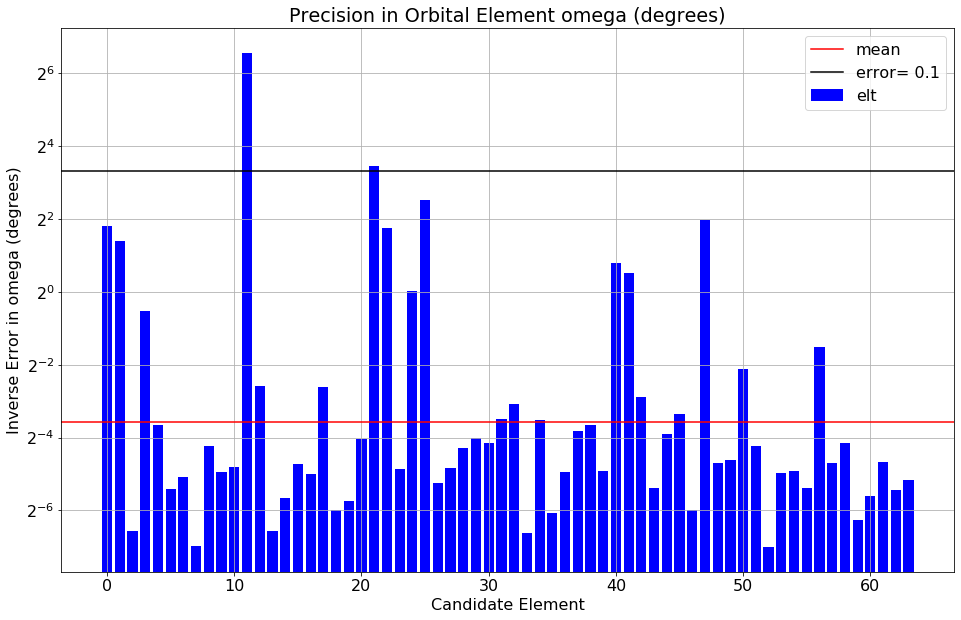

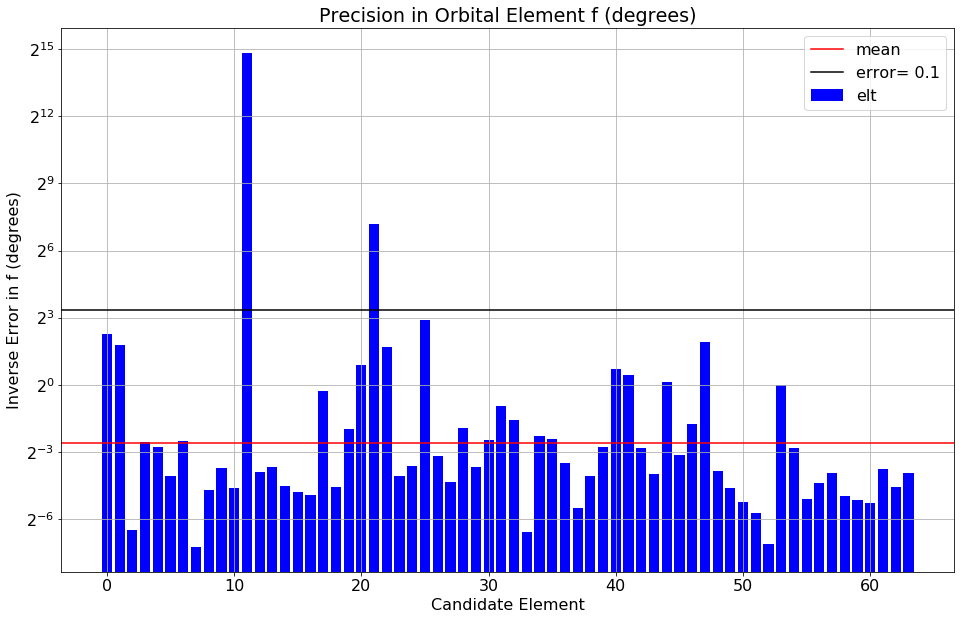

In [36]:
model.sieve()

In [37]:
model.report()


Good elements (hits >= 10):   9.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:  1131.16  : 136.22 :    11.67 :   747.41
Mean Bad :    53.90  :   0.11 :   210.75 :  2361.41
Mean     :   205.39  :  19.25 :   182.75 :  2134.44
Median   :    44.78  :   0.00 :   131.74 :  2400.00
GeoMean  :    69.24  :   1.08 :   110.94 :  1995.09
Min      :    16.88  :   0.00 :     6.52 :   379.38
Max      :  1312.89  : 173.00 :   760.34 :  2400.00
Trained for 13056 batches over 204 epochs and 64 episodes (elapsed time 680 seconds).


## Distance vs. Nearest Asteroid for Fitted Elements

In [38]:
_ = model.nearest_ast()

In [39]:
model.report()


Good elements (hits >= 10):   9.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:  1131.16  : 136.22 :    11.67 :   747.41
Mean Bad :    53.90  :   0.11 :   210.75 :  2361.41
Mean     :   205.39  :  19.25 :   182.75 :  2134.44
Median   :    44.78  :   0.00 :   131.74 :  2400.00
GeoMean  :    69.24  :   1.08 :   110.94 :  1995.09
Min      :    16.88  :   0.00 :     6.52 :   379.38
Max      :  1312.89  : 173.00 :   760.34 :  2400.00
Trained for 13056 batches over 204 epochs and 64 episodes (elapsed time 680 seconds).


In [40]:
# model.save_state()

In [41]:
# Review asteroids nearest to the fitted elements
cols = ['element_id', 'log_like', 'hits', 'R_sec', 'thresh_sec', 'nearest_ast_num', 'nearest_ast_dist', 'nearest_ast_q_norm']

# Summary
has_hits = (model.elts_fit.hits >= 10)
is_converged = has_hits
num_converged = np.sum(is_converged)

# Mean on converged
mean_hits = np.mean(model.elts_fit.hits[is_converged])
mean_R_sec = np.mean(model.elts_fit.R_sec[is_converged])
err_cart_mean = np.mean(model.elts_near_ast.nearest_ast_dist[is_converged])
err_cart_geo = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_dist[is_converged])))
err_cov_mean = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_q_norm[is_converged])))

# Report
print(f'Good convergence on {num_converged} asteroids.')
print(f'Mean on converged asteroids:')
print(f'Number of hits         : {mean_hits:5.2f}')
print(f'Resolution in arc sec  : {mean_R_sec:5.2f}')
# print(f'Mean Distance in AU    : {err_cart_mean:5.2e}')
print(f'GeoMean Distance in AU : {err_cart_geo:5.2e}')
print(f'Covariance norm        : {err_cov_mean:5.2e}')

Good convergence on 9 asteroids.
Mean on converged asteroids:
Number of hits         : 136.20
Resolution in arc sec  : 11.67
GeoMean Distance in AU : 1.87e-04
Covariance norm        : 1.87e-02


In [42]:
# Review good matches
model.elts_fit[cols][is_converged].sort_values(by=['hits', 'R_sec'], ascending=[False, True])

,element_id,log_like,hits,R_sec,thresh_sec,nearest_ast_num,nearest_ast_dist,nearest_ast_q_norm
11,9936,1312.892944,172.989655,9.578897,767.978821,9936,0.000049,0.002444
22,9229,1212.809814,162.970917,6.947262,913.373291,9229,0.000053,0.015894
41,3426,1107.103638,152.978348,6.522835,611.216858,3426,0.000227,0.048656
47,733,1054.600952,150.951050,7.928983,632.026855,733,0.000090,0.016183
21,77774,1164.738159,148.974686,13.464880,1129.628662,77774,0.000700,0.038037
40,31539,1157.598877,137.991028,8.013342,702.503052,31539,0.000696,0.040737
25,203722,947.969543,130.968353,7.657284,379.377106,203722,0.000125,0.008848
0,51921,1163.495361,109.978951,15.359585,583.395447,51921,0.000404,0.010514
1,59244,1059.194458,57.975670,29.585962,1007.230957,59244,0.000215,0.063018


In [43]:
# # Review fitted elements including nearest asteroid
model.elts_fit

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,...,thresh_deg,thresh_sec,log_like,hits,num_rows_close,H,sigma_mag,nearest_ast_num,nearest_ast_dist,nearest_ast_q_norm
0,51921,2.667627,0.217065,0.499373,4.699796,2.445836,-1.129902,58600.0,196.525879,0.000074,...,0.162054,583.395447,1163.495361,109.978951,222.0,14.989493,1.277606,51921,0.000404,0.010514
1,59244,2.634253,0.263081,0.464933,5.737998,1.773628,-1.606532,58600.0,191.502411,0.000143,...,0.279786,1007.230957,1059.194458,57.975670,237.0,16.484949,0.907221,59244,0.000215,0.063018
2,15786,1.915549,0.044076,0.379595,6.132883,0.779642,-1.247638,58600.0,10.332739,0.000273,...,0.666667,2399.999756,32.468006,0.000000,378.0,15.834867,1.274950,425432,0.004039,2.438130
3,3904,2.552686,0.083609,0.249322,5.560399,2.177424,-1.459745,58600.0,24.583986,0.001112,...,0.666537,2399.533691,41.757999,0.000000,345.0,14.230406,1.373082,3904,0.002612,0.419032
4,142999,2.515016,0.182370,0.503234,0.209825,0.941386,-1.342276,58600.0,16.131302,0.000230,...,0.664834,2393.403320,50.724350,0.000000,418.0,13.627530,1.637259,451765,0.012394,2.309447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,11952,1.758781,0.063083,0.072505,-0.056501,2.633646,-3.128021,58600.0,53.331493,0.001392,...,0.666667,2399.999756,36.662342,0.000000,752.0,15.846010,1.592979,258695,0.011988,2.997269
60,134815,2.348516,0.105205,0.486748,0.243827,0.690700,-1.004132,58600.0,9.828148,0.000413,...,0.666667,2399.999756,16.881744,0.000000,262.0,14.793008,1.102678,1055736,0.011074,2.028821
61,27860,2.597305,0.098522,0.194408,5.533845,3.256525,3.968553,58600.0,48.466793,0.000986,...,0.666667,2399.999756,47.390369,0.000000,993.0,13.189500,1.015024,1047580,0.004210,0.967218
62,85937,2.190697,0.219235,0.434224,5.242405,3.205337,3.922006,58600.0,21.748184,0.000845,...,0.657690,2367.685791,35.980316,0.000000,369.0,15.583706,1.550853,45947,0.012196,3.781629


In [44]:
# Add nearest_ast_dist column
model.elts_fit['nearest_ast_dist'] = model.elts_near_ast.nearest_ast_dist
model.elts_fit['nearest_ast_q_norm'] = model.elts_near_ast.nearest_ast_q_norm

# Filter for only the good ones
mask = (model.elts_fit.log_like > 200) & (model.elts_fit.R_sec < 40)
cols = ['element_id', 'num_hits', 'R_sec', 'thresh_sec', 'log_like', 'hits', 'nearest_ast_dist', 'nearest_ast_q_norm']
model.elts_fit[cols][mask].sort_values(by='R_sec')

,element_id,num_hits,R_sec,thresh_sec,log_like,hits,nearest_ast_dist,nearest_ast_q_norm
41,3426,150.853867,6.522835,611.216858,1107.103638,152.978348,0.000227,0.048656
22,9229,145.219391,6.947262,913.373291,1212.809814,162.970917,0.000053,0.015894
25,203722,133.013855,7.657284,379.377106,947.969543,130.968353,0.000125,0.008848
47,733,84.666779,7.928983,632.026855,1054.600952,150.951050,0.000090,0.016183
40,31539,155.404739,8.013342,702.503052,1157.598877,137.991028,0.000696,0.040737
11,9936,171.881744,9.578897,767.978821,1312.892944,172.989655,0.000049,0.002444
21,77774,165.516708,13.464880,1129.628662,1164.738159,148.974686,0.000700,0.038037
0,51921,196.525879,15.359585,583.395447,1163.495361,109.978951,0.000404,0.010514
1,59244,191.502411,29.585962,1007.230957,1059.194458,57.975670,0.000215,0.063018


In [45]:
# # Filter for incomplete convergence
# mask = (elts_fit.log_like > 200) & (elts_fit.R_sec >= 60)
# elts_fit[mask]

## Visualize Error vs. Nearest Asteroid

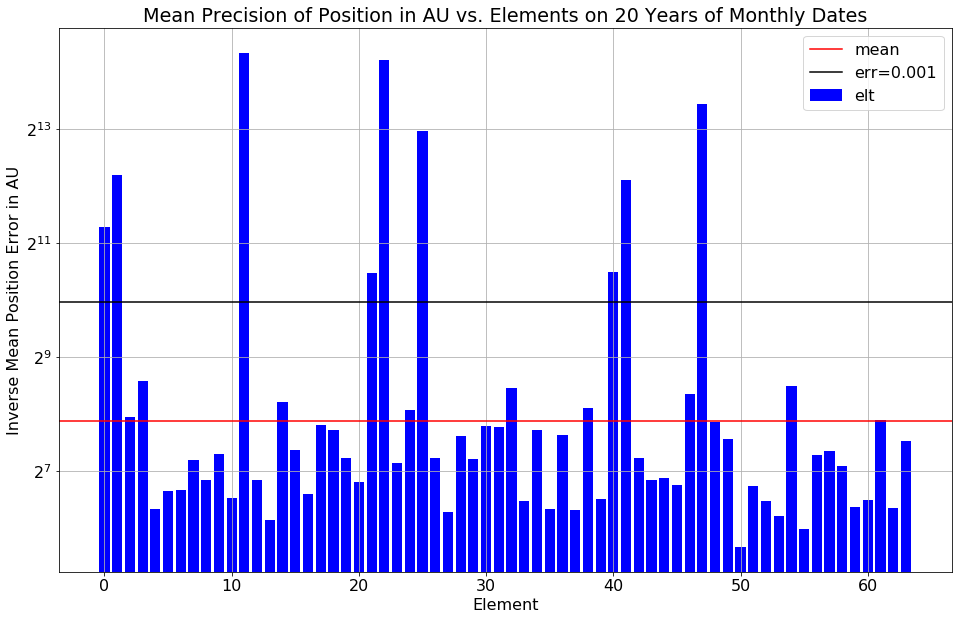

In [46]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(plot_type='cart', is_log=True, use_near_ast_dist=True)

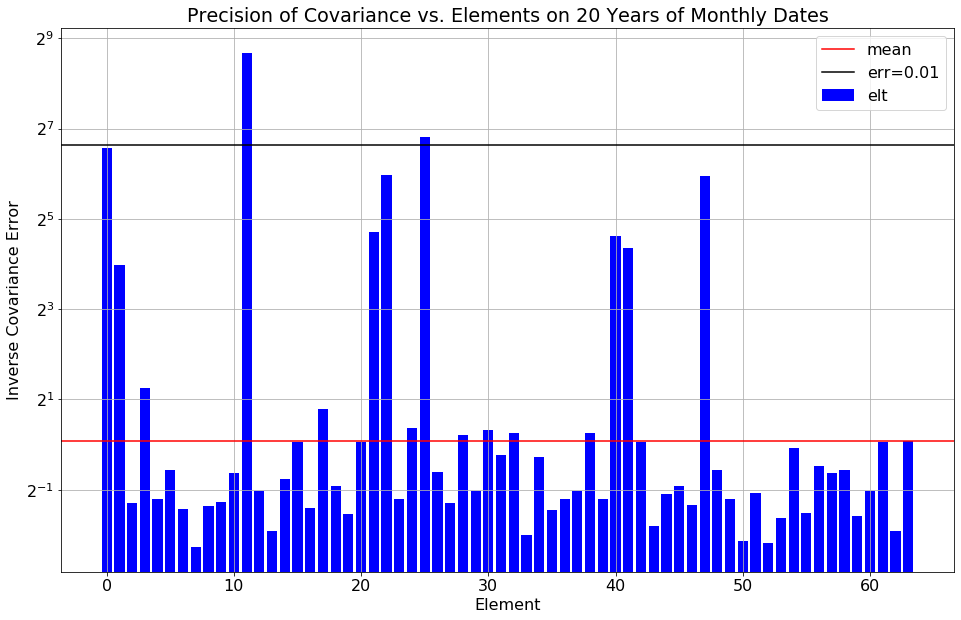

In [47]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(plot_type='cov', is_log=True, use_near_ast_dist=True)

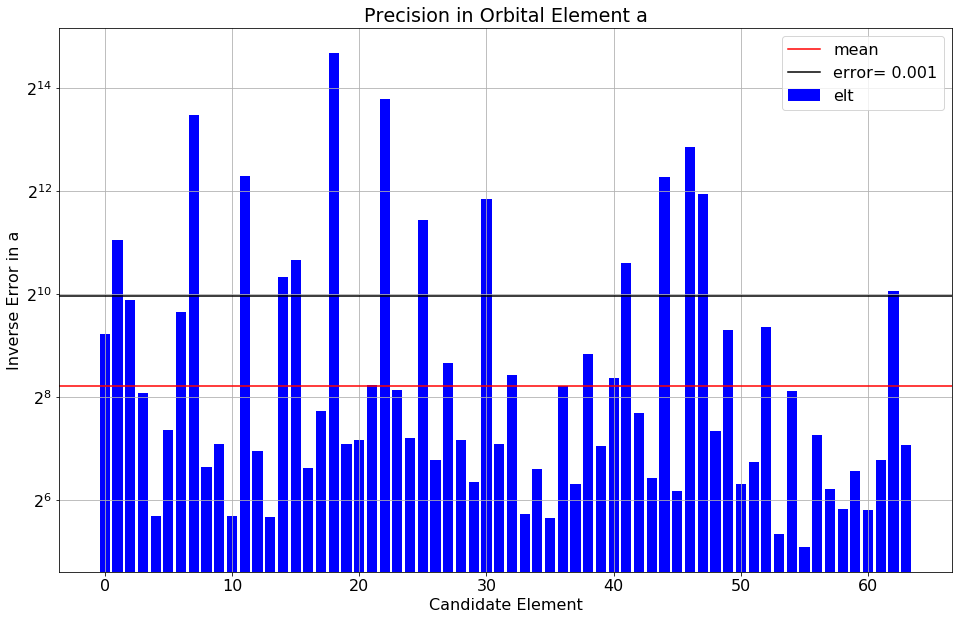

In [48]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='a', is_log=True)

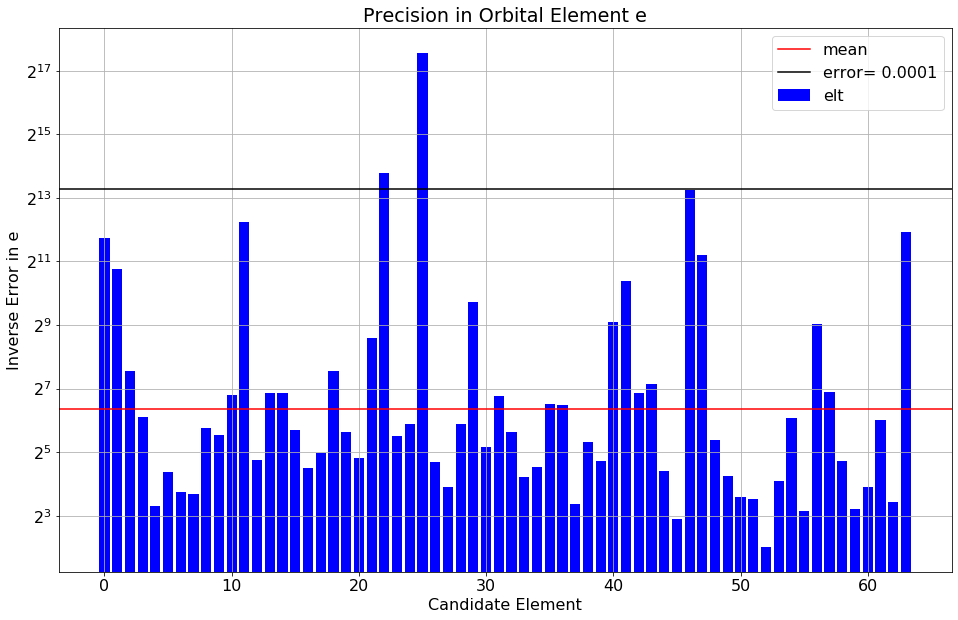

In [49]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='e', is_log=True)

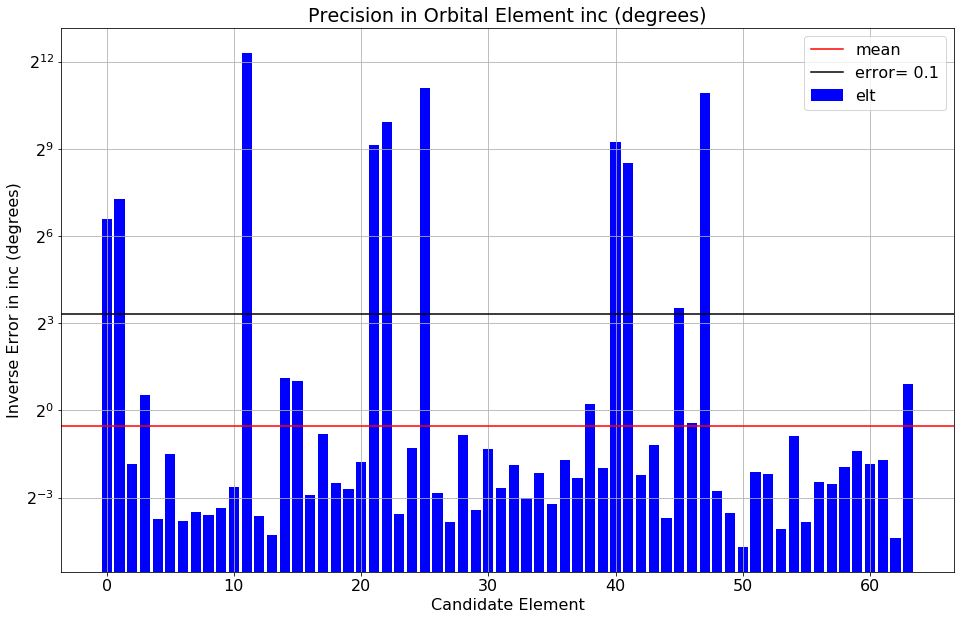

In [50]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='inc', is_log=True)

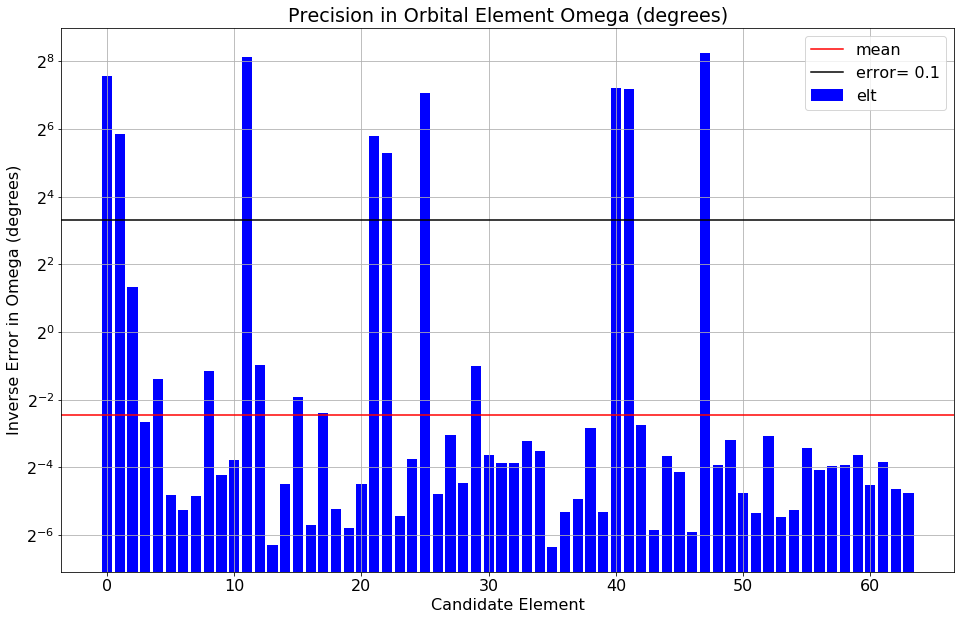

In [51]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='Omega', is_log=True)

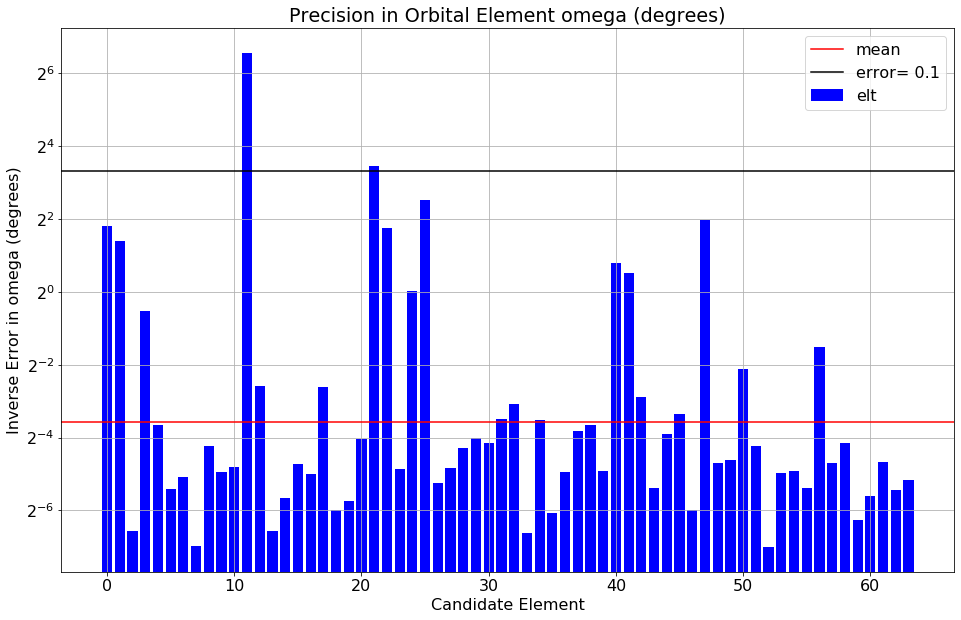

In [52]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='omega', is_log=True)

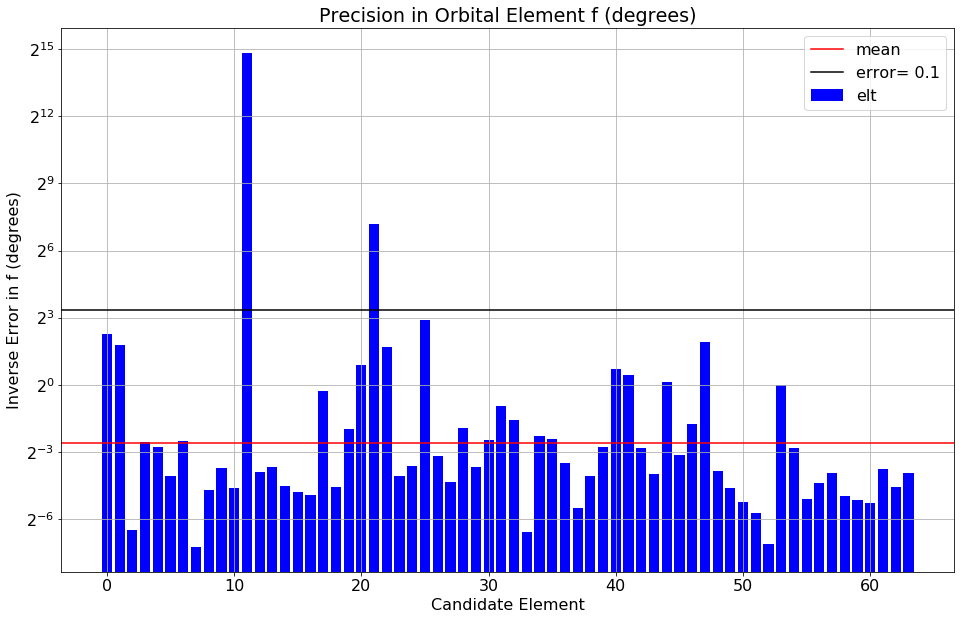

In [53]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='f', is_log=True)

In [54]:
model.candidates_df()

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,...,thresh_deg,thresh_sec,log_like,hits,num_rows_close,H,sigma_mag,weight_joint,weight_element,weight_mixture
0,51921,2.667627,0.217065,0.499373,4.699796,2.445836,-1.129902,58600.0,196.525879,0.000074,...,0.162054,583.395447,1163.495239,109.978966,222.0,14.989493,1.277606,0.500,1.0,0.1250
1,59244,2.634253,0.263081,0.464933,5.737998,1.773628,-1.606532,58600.0,191.502411,0.000143,...,0.279786,1007.230957,1059.194824,57.975670,237.0,16.484949,0.907221,1.000,1.0,0.0625
2,15786,1.915549,0.044076,0.379595,6.132883,0.779642,-1.247638,58600.0,10.332739,0.000273,...,0.666667,2399.999756,32.467850,0.000000,378.0,15.834867,1.274950,0.125,1.0,0.0625
3,3904,2.552686,0.083609,0.249322,5.560399,2.177424,-1.459745,58600.0,24.583986,0.001112,...,0.666537,2399.533691,41.758087,0.000000,345.0,14.230406,1.373082,0.125,1.0,0.1250
4,142999,2.515016,0.182370,0.503234,0.209825,0.941386,-1.342276,58600.0,16.131302,0.000230,...,0.664834,2393.403320,50.724323,0.000000,418.0,13.627530,1.637259,0.125,1.0,0.0625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,11952,1.758781,0.063083,0.072505,-0.056501,2.633646,-3.128021,58600.0,53.331493,0.001392,...,0.666667,2399.999756,36.662613,0.000000,752.0,15.846010,1.592979,0.125,1.0,0.0625
60,134815,2.348516,0.105205,0.486748,0.243827,0.690700,-1.004132,58600.0,9.828148,0.000413,...,0.666667,2399.999756,16.881321,0.000000,262.0,14.793008,1.102678,0.125,1.0,0.0625
61,27860,2.597305,0.098522,0.194408,5.533845,3.256525,3.968553,58600.0,48.466793,0.000986,...,0.666667,2399.999756,47.390373,0.000000,993.0,13.189500,1.015024,0.125,1.0,0.0625
62,85937,2.190697,0.219235,0.434224,5.242405,3.205337,3.922006,58600.0,21.748184,0.000845,...,0.657690,2367.685791,35.980225,0.000000,369.0,15.583706,1.550853,0.250,1.0,0.1250
